In [ ]:
import requests
import pandas as pd


df = pd.read_csv('verisk_sql_odys_80.tsv',sep='\t')


#change zip so its not a float and replace .0 so we can match the addresses

df['PostalCd'] = df['PostalCd'].astype(str).str.replace(r'\.0$', '', regex=True)
df['PostalCd'] = df['PostalCd'].fillna('')

#get authorization token from postman

post_url = 'https://gateway.verisk.com/underwriting/lender/auto/NameAndAddress/v1'
headers = {
    'Authorization': f'Bearer ****',
    'Content-Type': 'application/xml'
}
results = []

for index, row in df.iterrows():
    app_id = row['AppId']
    applicant_firstnm = row['applicant_firstnm']
    applicant_middlenm = row['applicant_middlenm']
    applicant_lastnm = row['applicant_lastnm']
    AptNo = row['AptNo']
    StreetNo = row['StreetNo']
    Street = row['Street']
    City = row['City']
    State = row['State']
    PostalCd = row['PostalCd']
    
    #xml body needed for request
    xml_data = f'''<Request>
    <Header>
        <Authorization>
            <LenderId>9289a4b2-fc6a-4862-91ec-32b136373e80</LenderId>
        </Authorization>
    </Header>
    <Body>
        <Drivers>
            <Driver>
                <Sequence>1</Sequence>
                <GivenName>{applicant_firstnm}</GivenName>
                <Surname>{applicant_lastnm}</Surname>
            </Driver>
        </Drivers>
        <Addresses>
            <Address>
                <AddressType>Current</AddressType>
                <Street1>{StreetNo} {Street}</Street1>
                <City>{City}</City>
                <StateCode>{State}</StateCode>
                <Zip>{PostalCd}</Zip>
            </Address>
        </Addresses>
    </Body>
</Request>'''
    
    
    response = requests.post(post_url, headers=headers, data=xml_data)
    
    #append the AppId and response to the results list
    results.append({'AppId': app_id, 'Response': response.text})
    
    if response.status_code != 200:
        
        print(f'Request for AppId {app_id} failed.')
        print(f'Status Code: {response.status_code}')
        print(f'Response: {response.text}')


responses_df = pd.DataFrame(results)

#save the appid+respone to a tsv file
responses_df.to_csv('new_verisk_odys80.tsv', sep='\t', index=False)

print('All responses have been saved to all_responses.tsv.')

In [81]:
df.columns

Index(['AppId', 'TypCd', 'dealdetailId', 'DecisionDate', 'applicant_firstnm',
       'applicant_middlenm', 'applicant_lastnm', 'CollateralId',
       'collateral_ranking', 'ActiveFlg', 'Tradeflg', 'AppFlg', 'VIN',
       'applicant_aptno', 'applicant_streetno', 'applicant_street',
       'applicant_streettyp', 'applicant_city', 'applicant_state',
       'applicant_zip', 'applicant_verisk', 'applicant_reportdt',
       'report_ranking'],
      dtype='object')

In [834]:
import json

#get the response
df_response = pd.read_csv('all_responses.tsv',sep='\t')

df_response.drop_duplicates('AppId',inplace=True)

#get the data we need from the sql query
df_vin = df[['AppId','VIN','DecisionDate']]

#merge the two dfs
df_spojeno = pd.merge(df_response,df_vin,how='left',on='AppId')

df_spojeno['DecisionDate'] = df_spojeno['DecisionDate'].dt.normalize()

#extract policies from response

def extract_policies(response_json):
    try:
        response_data = json.loads(response_json)
        policies = response_data.get('body', {}).get('policies', [])
        return policies
    except (json.JSONDecodeError, AttributeError):
        return [] 

#extract transaction info based on policies and decision date
#effectivedate from transaction history needs to be before decision date

def extract_transaction_info(policies_json, decision_date):
    try:
        policies_data = json.loads(policies_json)
        policies = policies_data.get('body', {}).get('policies', [])
        
        results = []
        for policy in policies:
            history = policy.get('history', {})
            transaction_infos = history.get('transactionInformations', [])
            
            policy_transactions = []
            for transaction_info in transaction_infos:
                effective_date_str = transaction_info.get('effectiveDate')
                effective_date = pd.to_datetime(effective_date_str)
                effective_date_normalized = effective_date.date()
                
                #convert decision_date to datetime.date for comparison
                decision_date = pd.to_datetime(decision_date).date()
                
                if effective_date_normalized < decision_date:
                    policy_transactions.append({
                        'description': transaction_info.get('transactionType', {}).get('description'),
                        'effectiveDate': effective_date_normalized
                    })
            
            results.append(policy_transactions)
        
        return results
    
    except (json.JSONDecodeError, AttributeError, KeyError):
        return []

#apply the functions
df_spojeno['policies'] = df_spojeno['Response'].apply(extract_policies)
df_spojeno['transaction_info'] = df_spojeno.apply(lambda row: extract_transaction_info(row['Response'], row['DecisionDate']), axis=1)

#make separate columns for each app id that has multiple 
def expand_columns(row):
    policies = row['policies']
    transaction_info = row['transaction_info']
    
    max_policies = 5  #max num of policies to extract
    for i in range(max_policies):
        policy_col = f'policy{i+1}'
        transaction_col = f'transaction_info{i+1}'
        
        if i < len(policies):
            row[policy_col] = policies[i]  
            row[transaction_col] = transaction_info[i] if i < len(transaction_info) else []
        else:
            row[policy_col] = {} 
            row[transaction_col] = []  
    
    return row

#apply the function to expand columns
df_spojeno = df_spojeno.apply(expand_columns, axis=1)


if 'policies' in df_spojeno.columns and 'transaction_info' in df_spojeno.columns:
    df_spojeno.drop(['policies', 'transaction_info'], axis=1, inplace=True)

#df_spojeno['policies'] = df_spojeno['policies'].apply(lambda x: '' if x == [] else x)

In [835]:
#function to check specific descriptions which cancel each other out

#if intent to cancel is after rescind intent then we shouldn't consider policy as active and vice versa

columns_to_apply = ['transaction_info1','transaction_info2','transaction_info3','transaction_info4','transaction_info5']
columns_to_make = ['active_intent_rescind1','active_intent_rescind2','active_intent_rescind3','active_intent_rescind4','active_intent_rescind5']

def determine_active(transaction_list):
    if not isinstance(transaction_list, list):
        return None
    
    cancel_date = None
    rescind_date = None
    cancel_index = -1
    rescind_index = -1
    
    #iterate through desc and eff date
    for i, transaction in enumerate(transaction_list):
        if 'description' in transaction and 'effectiveDate' in transaction:
            description = transaction['description']
            effective_date = pd.to_datetime(transaction['effectiveDate'])
            
            #match the corresponding dates to descr
            if description == 'Intent to Cancel Policy' or description == 'Notice of Intent to Cancel, NON-PAY':
                cancel_date = effective_date
                cancel_index = i
            elif description == 'Rescind Intent to Cancel/Non-Renew' or description == 'Renewal':
                rescind_date = effective_date
                rescind_index = i
                
    #check if cancel date is after rescind and vice versa
    if cancel_date is not None and rescind_date is not None:
        if cancel_date > rescind_date:
            return False
        elif rescind_date > cancel_date:
            return True
        #if they have same dates consider the one with the higher index 
        elif cancel_date == rescind_date:
            return rescind_index > cancel_index
        
    #if only cancel is found set it as false
    
    elif cancel_date is not None and rescind_date is None:
        return False
    
    
    return None

#apply the function

for i in range(len(columns_to_apply)):
    df_spojeno[columns_to_make[i]] = df_spojeno[columns_to_apply[i]].apply(determine_active)
    
#we should do the same for cancel and renew 

columns_to_apply = ['transaction_info1','transaction_info2','transaction_info3','transaction_info4','transaction_info5']
columns_to_make = ['active_renewal1','active_renewal2','active_renewal3','active_renewal4','active_renewal5']

    

def determine_active_2(transaction_list):
    
   
    if not isinstance(transaction_list, list):
        return None
    
    cancel_date = None
    renewal_date = None
    cancel_index = -1
    renewal_index = -1
    
    #iterate through desc and eff date
    for i, transaction in enumerate(transaction_list):
        if 'description' in transaction and 'effectiveDate' in transaction:
            description = transaction['description']
            effective_date = pd.to_datetime(transaction['effectiveDate'])
            
            #match the corresponding dates to descr
            if description in ['Cancel', 'Cancellation', 'Cancellation - Returned Check (NSF)', 'Comp Cancel - Non Pay','FLAT CANCELS DIFF EFF INCP DATES']:
                cancel_date = effective_date
                cancel_index = i
            elif description in ['Renewal', 'Reinstatement - Lapse in CVG' ,'Reinstatement']:
                renewal_date = effective_date
                renewal_index = i
                
    #check if cancel date is after renewal and vice versa
    
    if cancel_date is not None and renewal_date is not None:
        if cancel_date > renewal_date:
            return False
        elif renewal_date > cancel_date:
            return True
        #if they have same date consider the one with the higher index
        elif cancel_date == renewal_date:
            return renewal_index > cancel_index
        
    #if only cancel is found set it as false
    
    elif cancel_date is not None and renewal_date is None:
        return False
    
    return None

#apply to the columns

for i in range(len(columns_to_apply)):
    df_spojeno[columns_to_make[i]] = df_spojeno[columns_to_apply[i]].apply(determine_active_2)

In [859]:
def determine_status(row):
    for i in range(1, 4):
        transaction_info = row[f'transaction_info{i}']
        rescind = row[f'active_intent_rescind{i}']
        renewal = row[f'active_renewal{i}']
        
        if transaction_info and rescind in [True, '', None] and renewal in [True, '', None]:
            first_effective_date = transaction_info[0]['effectiveDate']  #get the first effective date
            last_effective_date = transaction_info[-1]['effectiveDate']  #get the last effective date
            decision_date = row['DecisionDate'].date()  #convert DecisionDate to date
            
            date_diff = relativedelta(decision_date, first_effective_date)
            days_diff = (decision_date - first_effective_date).days
            months_diff = (date_diff.years * 12) + date_diff.months
            
            if relativedelta(decision_date, last_effective_date).years < 1:  #last effective date within a year
                return 'Active', f'transaction_info{i}', months_diff, days_diff

    return 'Inactive', None, None, None
#apply function to each row and unpack the results
df_spojeno[['Status', 'ActiveTransactionInfo', 'DateDifference','DateDifferenceDays']] = df_spojeno.apply(determine_status, axis=1, result_type='expand')
df_spojeno['DateDifference'] = df_spojeno['DateDifference'].astype(str).str.replace(r'\.0$', '', regex=True)
df_spojeno['DateDifferenceDays'] = df_spojeno['DateDifferenceDays'].astype(str).str.replace(r'\.0$', '', regex=True)
df_spojeno.replace('nan','',inplace=True)

In [877]:
df_spojeno[df_spojeno['Status'] == 'Active']['DateDifferenceDays'].astype(float).mean()

230.8867635807192

In [878]:
df_spojeno[df_spojeno['Status'] == 'Active']['DateDifference'].astype(float).mean()

7.169854628921193

In [869]:
df_spojeno.replace('nan','',inplace=True)

In [ ]:
df_spojeno.to_csv('testiraj5_intent_rescind.tsv',sep='\t',index=False)

In [64]:
import pandas as pd
from datetime import datetime
df = pd.read_csv('izracunaj_old_new.tsv',sep='\t')
df

,AppId,VIN,DecisionDate,policy1,policy2,policy3,policy4,policy5
0,9790613,1FMCU0F74JUB80076,2024-01-05,"{'policyNumber': '6126394458', 'policyStatus':...",{},{},{},{}
1,9766477,2G1FA1EV5A9225645,2024-01-09,"{'policyNumber': '10122897701', 'policyStatus'...",{},{},{},{}
2,9792542,KNAFX4A85E5236037,2024-01-08,"{'policyNumber': '3815632510001', 'policyStatu...","{'policyNumber': '3815737274001', 'policyStatu...","{'policyNumber': '3815632510003', 'policyStatu...","{'policyNumber': '3815632510002', 'policyStatu...","{'policyNumber': '5837J115923', 'policyStatus'..."
3,9787916,1GNSCHKC4JR171585,2024-01-10,"{'policyNumber': 'TXPA06796262', 'policyStatus...",{},{},{},{}
4,9800102,5YJ3E1EA9MF100580,2024-01-04,"{'policyNumber': '5314514175001', 'policyStatu...","{'policyNumber': '5314514175002', 'policyStatu...",{},{},{}
...,...,...,...,...,...,...,...,...
1608,9885576,2G11Z5S39L9105976,2024-01-29,"{'policyNumber': '0135980300', 'policyStatus':...","{'policyNumber': '0135327899', 'policyStatus':...","{'policyNumber': '0135327898', 'policyStatus':...",{},{}
1609,9868676,2HGFC2F88LH546816,2024-01-30,"{'policyNumber': 'Q6M44D', 'policyStatus': 'IN...","{'policyNumber': '96CMRX', 'policyStatus': 'CA...","{'policyNumber': 'WZJKF3', 'policyStatus': 'CA...",{},{}
1610,9869169,KNMAT2MT2KP517449,2024-01-29,"{'policyNumber': '2021522109', 'policyStatus':...","{'policyNumber': '2019573808', 'policyStatus':...",{},{},{}
1611,9903936,5NPE34AF3GH427628,2024-01-30,"{'policyNumber': '3213427753', 'policyStatus':...","{'policyNumber': '3211934989', 'policyStatus':...","{'policyNumber': '3211934990', 'policyStatus':...","{'policyNumber': '3212325429', 'policyStatus':...",{}


In [73]:
import pandas as pd
from datetime import datetime

#parse date strings
def parse_date(date_str):
    return datetime.strptime(date_str, '%Y%m%d')

#function to count policies based on the conditions
def process_policies(record):
    result = {
        'AppId': record['AppId'],
        'count_old_policies': 0,
        'count_old_policies_cancelled': 0,
        'count_old_continuous_policies': 0,
        'count_new_policies': 0,
        'count_new_policies_cancelled': 0,
        'count_new_continuous_policies': 0
    }

    vin_query = record['VIN']
    decision_date = datetime.strptime(record['DecisionDate'], '%Y-%m-%d')

    cancel_phrases = [
        'Cancel', 'Cancellation', 'Cancellation - Returned Check (NSF)',
        'Comp Cancel - Non Pay', 'FLAT CANCELS DIFF EFF INCP DATES'
    ]

    for i in range(1, 6):
        policy_key = f'policy{i}'
        policy_data = record.get(policy_key)
        if policy_data:
            policy = eval(policy_data)  

            #ensure 'detail' and 'vehicles' exist and vehicle has 'vin'
            if 'detail' in policy and 'vehicles' in policy['detail'] and len(policy['detail']['vehicles']) > 0 and 'vin' in policy['detail']['vehicles'][0]:
                vin_policy = policy['detail']['vehicles'][0]['vin']
                transactions = policy['history'].get('transactionInformations', [])

                #check if there are transactions
                if transactions:
                    first_transaction_date = parse_date(transactions[0]['effectiveDate'])
                    
                    #check if first transaction date is not after decision date
                    if first_transaction_date < decision_date:
                        is_new_policy = vin_policy == vin_query
                        is_old_policy = not is_new_policy

                        #count old and new policies only if transactions exist
                        if is_old_policy:
                            result['count_old_policies'] += 1
                        if is_new_policy:
                            result['count_new_policies'] += 1

                        #check for cancellations and continuous renewals
                        cancel_found = False
                        rescind_found = False

                        for transaction in transactions:
                            description = transaction['transactionType']['description']

                            
                            if 'Intent to Cancel Policy' in description:
                                cancel_found = True

                            
                            if 'Rescind Intent to Cancel/Non-Renew' in description:
                                rescind_found = True

                            
                            if any(phrase.lower() in description.lower() for phrase in cancel_phrases):
                                cancel_found = True

                        #count policies based on cancellation conditions
                        if is_old_policy:
                            if cancel_found and not rescind_found:
                                result['count_old_policies_cancelled'] += 1

                            if not cancel_found and (decision_date - first_transaction_date).days >= 365:
                                result['count_old_continuous_policies'] += 1
                            elif cancel_found and rescind_found:
                                #check if it's continuous after rescind
                                if all(not any(phrase.lower() in t['transactionType']['description'].lower() for phrase in cancel_phrases) for t in transactions):
                                    result['count_old_continuous_policies'] += 1

                        if is_new_policy:
                            if cancel_found and not rescind_found:
                                result['count_new_policies_cancelled'] += 1

                            if not cancel_found and (decision_date - first_transaction_date).days >= 180:
                                result['count_new_continuous_policies'] += 1
                            elif cancel_found and rescind_found:
                                #check if it's continuous after rescind
                                if all(not any(phrase.lower() in t['transactionType']['description'].lower() for phrase in cancel_phrases) for t in transactions):
                                    result['count_new_continuous_policies'] += 1

    return result



#apply the function to each record
results = df.apply(process_policies, axis=1)
results_df = pd.DataFrame(results.tolist())

results_df


,AppId,count_old_policies,count_old_policies_cancelled,count_old_continuous_policies,count_new_policies,count_new_policies_cancelled,count_new_continuous_policies
0,9790613,0,0,0,1,0,1
1,9766477,1,0,0,0,0,0
2,9792542,5,0,1,0,0,0
3,9787916,1,0,0,0,0,0
4,9800102,2,0,1,0,0,0
...,...,...,...,...,...,...,...
1608,9885576,2,0,2,1,0,0
1609,9868676,0,0,0,1,0,0
1610,9869169,1,1,0,1,1,0
1611,9903936,3,0,3,1,0,0


In [74]:
results_df[results_df['AppId'] == 9804177]

,AppId,count_old_policies,count_old_policies_cancelled,count_old_continuous_policies,count_new_policies,count_new_policies_cancelled,count_new_continuous_policies
885,9804177,0,0,0,0,0,0


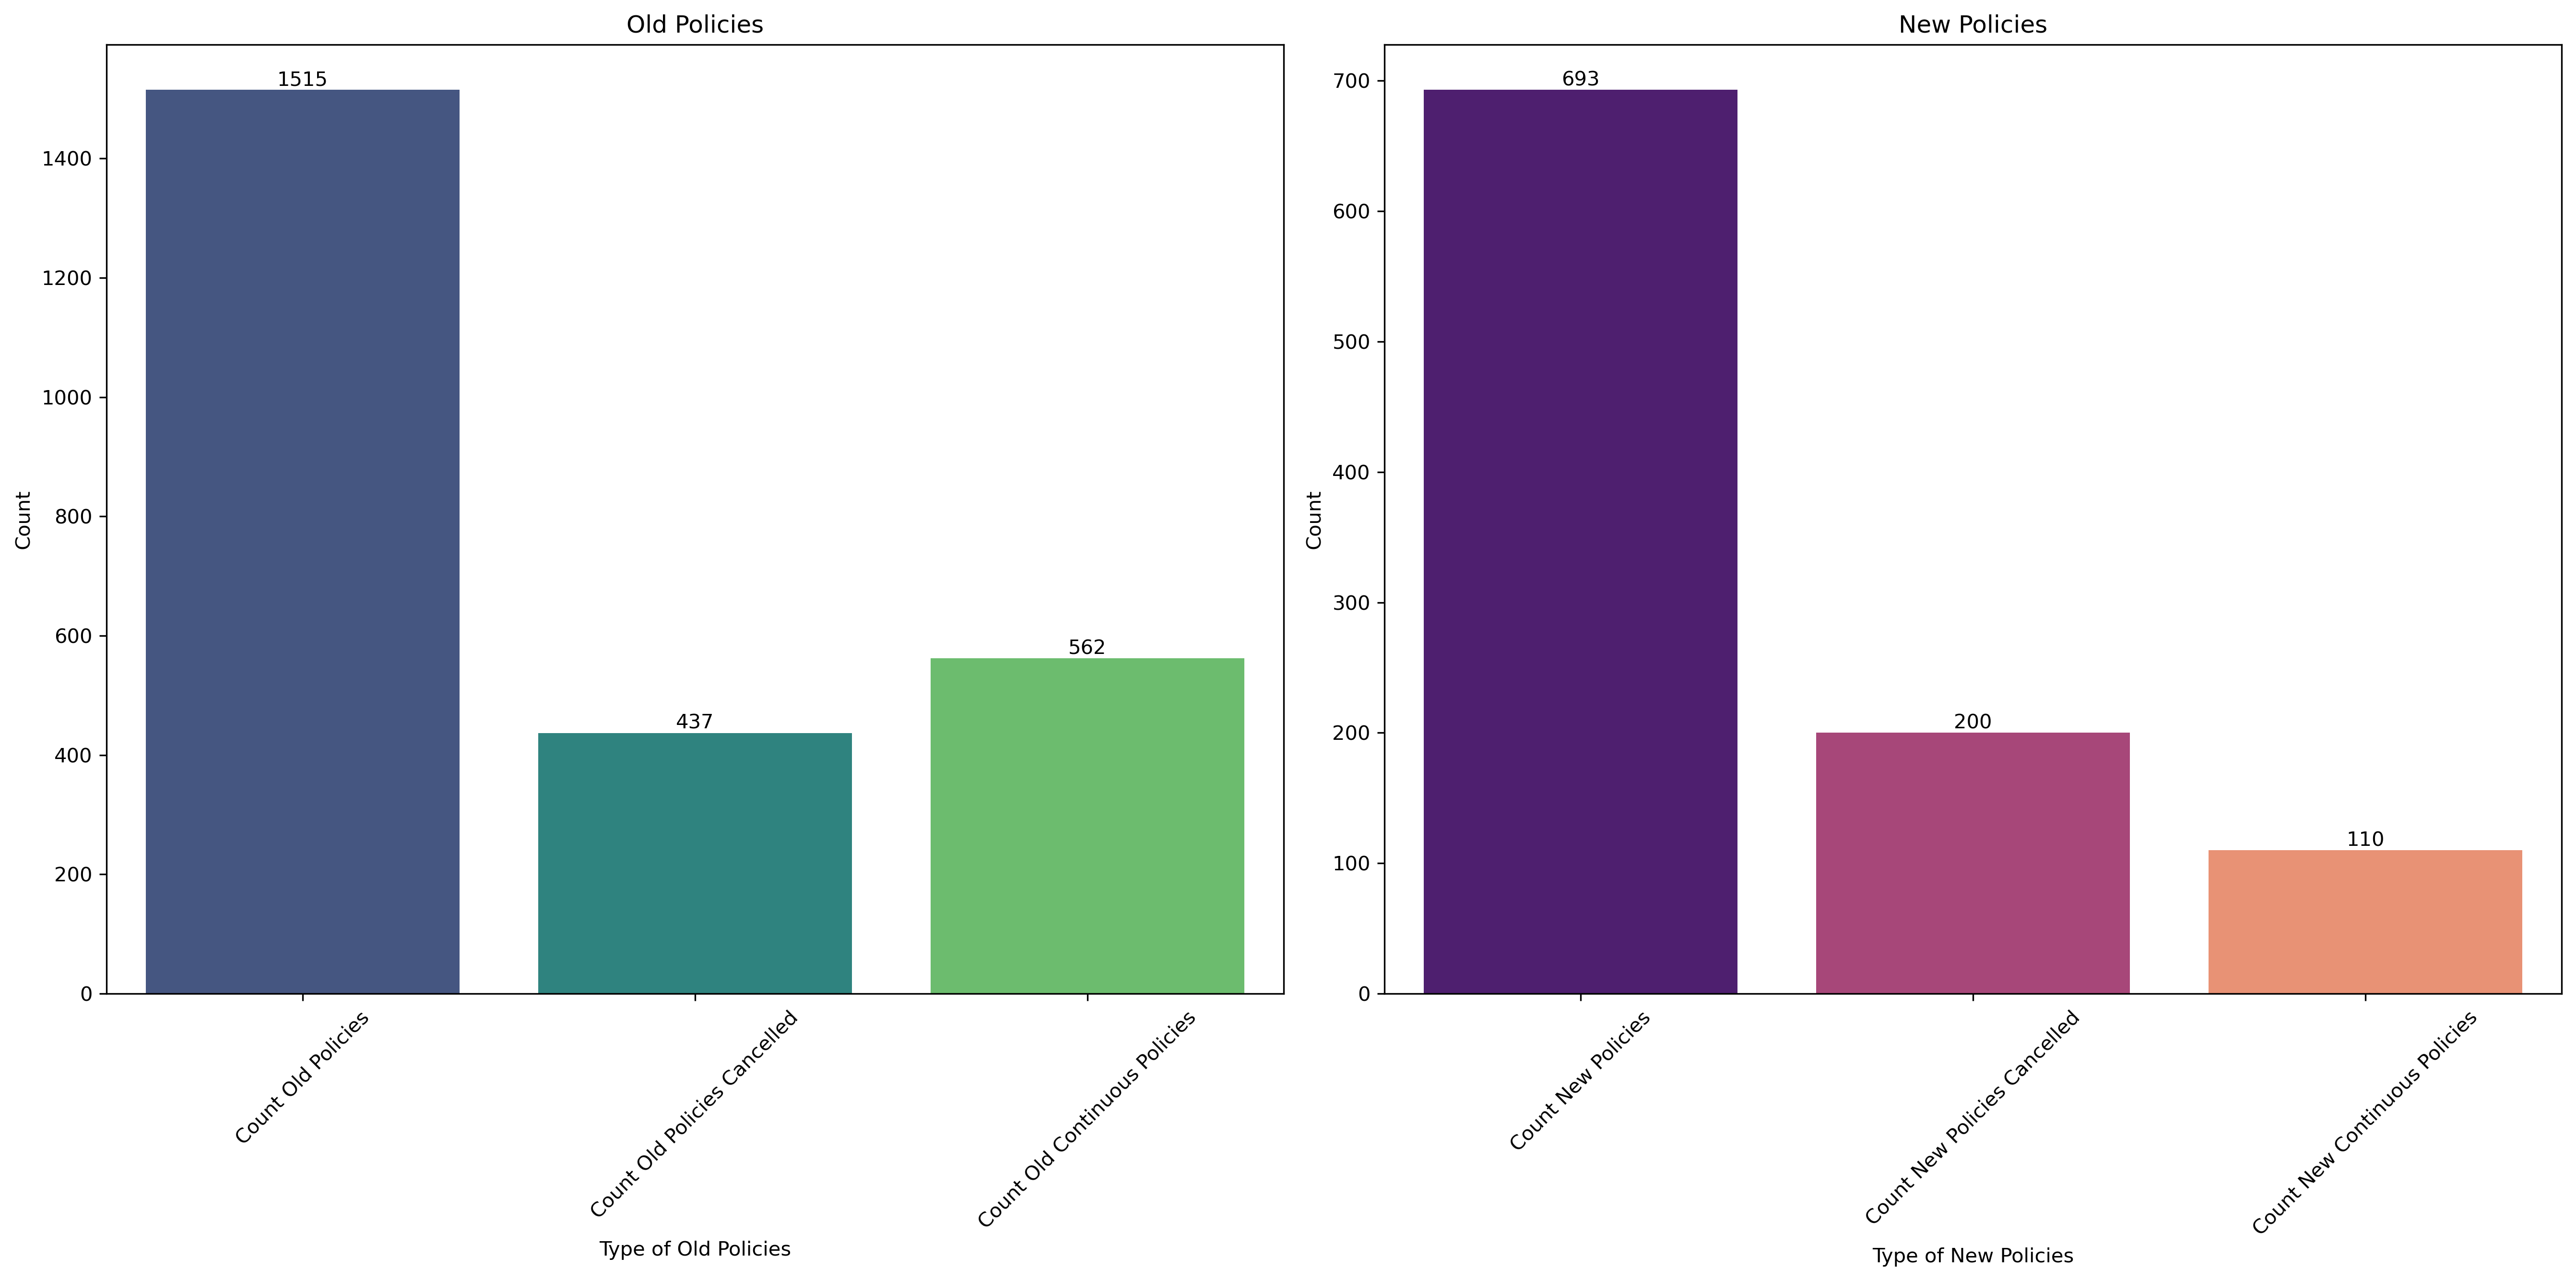

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

#normalize the names for x-ticks
def normalize_name(name):
    return ' '.join(word.capitalize() for word in name.split('_'))


plt.figure(figsize=(18, 9),dpi=300)

#old policies graph
plt.subplot(1, 2, 1)
old_policies_data = results_df[['count_old_policies', 'count_old_policies_cancelled', 'count_old_continuous_policies']].sum()
old_policies_data.index = old_policies_data.index.map(normalize_name)
sns.barplot(x=old_policies_data.index, y=old_policies_data.values, palette='viridis')
plt.title('Old Policies')
plt.ylabel('Count')
plt.xlabel('Type of Old Policies')
plt.xticks(rotation=45)
for index, value in enumerate(old_policies_data.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

#new policies graph
plt.subplot(1, 2, 2)
new_policies_data = results_df[['count_new_policies', 'count_new_policies_cancelled', 'count_new_continuous_policies']].sum()
new_policies_data.index = new_policies_data.index.map(normalize_name)
sns.barplot(x=new_policies_data.index, y=new_policies_data.values, palette='magma')
plt.title('New Policies')
plt.ylabel('Count')
plt.xlabel('Type of New Policies')
plt.xticks(rotation=45)
for index, value in enumerate(new_policies_data.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('new_old2.png')
plt.show()


In [77]:
results_df.to_csv('izracunato.tsv',sep = '\t',index=False)

In [54]:
import pandas as pd
from datetime import datetime

#parse date strings
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m-%d')
    except ValueError:
        return datetime.strptime(date_str, '%Y%m%d')

#function to count policies based on the conditions
def process_policies(record):
    result = {
        'AppId': record['AppId'],
        'count_old_policies': 0,
        'count_old_policies_cancelled': 0,
        'count_old_continuous_policies': 0,
        'count_new_policies': 0,
        'count_new_policies_cancelled': 0,
        'count_new_continuous_policies': 0
    }

    vin_query = record['VIN']
    decision_date = parse_date(record['DecisionDate'])

    cancel_phrases = [
        'Cancel', 'Cancellation', 'Cancellation - Returned Check (NSF)',
        'Comp Cancel - Non Pay', 'FLAT CANCELS DIFF EFF INCP DATES'
    ]
    rescind_phrase = 'Rescind Intent to Cancel/Non-Renew'

    for i in range(1, 6):
        policy_key = f'policy{i}'
        policy_data = record.get(policy_key)
        if policy_data:
            policy = eval(policy_data)  #convert string to dictionary

            #check for 'detail' and 'vehicles' and 'vin'
            if 'detail' in policy and 'vehicles' in policy['detail'] and len(policy['detail']['vehicles']) > 0 and 'vin' in policy['detail']['vehicles'][0]:
                vin_policy = policy['detail']['vehicles'][0]['vin']
                is_new_policy = vin_policy == vin_query
                is_old_policy = not is_new_policy

                #count old and new policies
                if is_old_policy:
                    result['count_old_policies'] += 1
                if is_new_policy:
                    result['count_new_policies'] += 1

                #check for cancellations and continuous renewals
                transactions = policy['history'].get('transactionInformations', [])
                if transactions:
                    cancel_transactions = [
                        t for t in transactions
                        if any(phrase.lower() in t['transactionType']['description'].lower() for phrase in cancel_phrases)
                    ]

                    if is_old_policy:
                        if cancel_transactions:
                            #check for rescind after intent to cancel
                            intent_to_cancel_found = False
                            for idx, transaction in enumerate(transactions):
                                if 'description' in transaction['transactionType'] and rescind_phrase.lower() in transaction['transactionType']['description'].lower():
                                    #check if preceded by intent to cancel
                                    if intent_to_cancel_found:
                                        result['count_old_policies_cancelled'] += 1
                                        break  #found rescind after intent to cancel
                                elif 'description' in transaction['transactionType'] and 'intent to cancel' in transaction['transactionType']['description'].lower():
                                    intent_to_cancel_found = True

                            #if no rescind after intent to cancel, count as cancelled
                            if not intent_to_cancel_found:
                                result['count_old_policies_cancelled'] += 1

                            #check for continuous policies
                            first_transaction_date = parse_date(transactions[0]['effectiveDate'])
                            last_non_cancel_date = None
                            for transaction in transactions:
                                if not any(phrase.lower() in transaction['transactionType']['description'].lower() for phrase in cancel_phrases):
                                    last_non_cancel_date = parse_date(transaction['effectiveDate'])
                                    break

                            if last_non_cancel_date and (decision_date - last_non_cancel_date).days >= 180:
                                result['count_old_continuous_policies'] += 1

                    if is_new_policy:
                        if cancel_transactions:
                            intent_to_cancel_found = False
                            for idx, transaction in enumerate(transactions):
                                if 'description' in transaction['transactionType'] and rescind_phrase.lower() in transaction['transactionType']['description'].lower():
                                    #check if preceded by intent to cancel
                                    if intent_to_cancel_found:
                                        result['count_new_policies_cancelled'] += 1
                                        break  #found rescind after intent to cancel
                                elif 'description' in transaction['transactionType'] and 'intent to cancel' in transaction['transactionType']['description'].lower():
                                    intent_to_cancel_found = True


                            if not intent_to_cancel_found:
                                result['count_new_policies_cancelled'] += 1

                            #check for continuous policies
                            first_transaction_date = parse_date(transactions[0]['effectiveDate'])
                            last_non_cancel_date = None
                            for transaction in transactions:
                                if not any(phrase.lower() in transaction['transactionType']['description'].lower() for phrase in cancel_phrases):
                                    last_non_cancel_date = parse_date(transaction['effectiveDate'])
                                    break

                            if last_non_cancel_date and (decision_date - last_non_cancel_date).days >= 180:
                                result['count_new_continuous_policies'] += 1

    return result


results = df.apply(process_policies, axis=1)
results_df = pd.DataFrame(results.tolist())

results_df


,AppId,count_old_policies,count_old_policies_cancelled,count_old_continuous_policies,count_new_policies,count_new_policies_cancelled,count_new_continuous_policies
0,9836874,0,0,0,1,0,0


In [3]:
df = pd.read_csv('new_verisk.tsv',sep = '\t')
df

,AppId,Response
0,10267316,"{""header"":{""transactionId"":""5636fe89-489f-4f5a..."
1,10268295,"{""header"":{""transactionId"":""21dda48b-b84d-4f9f..."
2,10268697,"{""header"":{""transactionId"":""f143f5b0-4b7e-44a9..."
3,10285814,"{""header"":{""transactionId"":""509aebea-39d4-4a71..."
4,10288847,"{""header"":{""transactionId"":""6bf0c773-547b-4780..."
...,...,...
308,10364508,"{""header"":{""transactionId"":""3d730f24-edc5-4c16..."
309,10364615,"{""header"":{""transactionId"":""e5692982-a54b-4c25..."
310,10364645,"{""header"":{""transactionId"":""82309353-6a67-4412..."
311,10364910,"{""header"":{""transactionId"":""326c3730-602f-4eb5..."


In [4]:
df1 = pd.read_csv('verisk_current_contr.tsv',sep='\t')
df1

,AppId,TypCd,dealdetailId,DecisionDate,applicant_firstnm,applicant_middlenm,applicant_lastnm,CollateralId,collateral_ranking,ActiveFlg,...,applicant_aptno,applicant_streetno,applicant_street,applicant_streettyp,applicant_city,applicant_state,applicant_zip,applicant_verisk,applicant_reportdt,report_ranking
0,10267316,C,16278301,2024-07-12 11:47:41.103,DAVANTAE,NaN,MCGARVEY,11000506,1,True,...,321,3786,Hitchcock,Way,Myrtle Beach,SC,29577,"<Response CustomerID=""10350644"" InvalidFlg=""0""...",2024-07-08 07:48:42.530,1
1,10268295,C,16252814,2024-07-16 07:09:07.180,ARTURO,E,ZARATE,10985410,1,True,...,NaN,1807,N Washington,St,Wilmington,DE,19802,"<Response CustomerID=""10337703"" InvalidFlg=""0""...",2024-07-15 10:01:04.370,1
2,10268697,C,16318553,2024-07-15 15:50:09.267,DEANGELO,NaN,DEWBERRY,11022243,1,True,...,DOWN,3335,EAST 140TH,ST,CLEVELAND,OH,44120,"<Response CustomerID=""10369254"" InvalidFlg=""0""...",2024-07-16 10:02:34.910,1
3,10285814,C,16326698,2024-07-16 08:49:50.923,MARIO JORGE,NaN,LUZ,11026589,1,True,...,NaN,276,Main,St,Hudson,MA,1749,"<Response CustomerID=""10372906"" InvalidFlg=""0""...",2024-07-16 10:02:07.613,1
4,10288847,C,16337447,2024-07-17 14:11:47.217,KENDRIA,NaN,BLACKWELL,11032275,1,True,...,NaN,7100,Daisy,St,Columbus,GA,31904,"<Response CustomerID=""10377623"" InvalidFlg=""0""...",2024-07-17 14:11:43.017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,10364508,C,16339097,2024-07-17 16:52:38.723,DAMION,NaN,MADISON,11033071,1,True,...,NaN,258,Independence,St,Portsmouth,VA,23701,"<Response CustomerID=""10378328"" InvalidFlg=""0""...",2024-07-17 16:52:34.433,1
309,10364615,C,16338985,2024-07-17 16:33:55.347,ROBERT,C,NAVARRO,11033005,1,True,...,NaN,182,Chrisman,Ave,Ventura,CA,93001,"<Response CustomerID=""10378269"" InvalidFlg=""0""...",2024-07-17 16:33:53.670,1
310,10364645,C,16339452,2024-07-17 19:18:30.577,MELANIE,D,DIXON,11033256,1,True,...,NaN,5550,Alfred,Dr,Las Vegas,NV,89108,"<Response CustomerID=""10378503"" InvalidFlg=""0""...",2024-07-17 19:18:26.570,1
311,10364910,C,16339297,2024-07-18 07:03:15.917,BERTA,NaN,SORTO,11033166,1,True,...,NaN,5431,5th,Ave,Fort Myers,FL,33907,"<Response CustomerID=""10378412"" InvalidFlg=""0""...",2024-07-17 17:42:09.363,1


In [6]:
df_merged = pd.merge(df,df1,on='AppId',how='inner')
df_merged

,AppId,Response,TypCd,dealdetailId,DecisionDate,applicant_firstnm,applicant_middlenm,applicant_lastnm,CollateralId,collateral_ranking,...,applicant_aptno,applicant_streetno,applicant_street,applicant_streettyp,applicant_city,applicant_state,applicant_zip,applicant_verisk,applicant_reportdt,report_ranking
0,10267316,"{""header"":{""transactionId"":""5636fe89-489f-4f5a...",C,16278301,2024-07-12 11:47:41.103,DAVANTAE,NaN,MCGARVEY,11000506,1,...,321,3786,Hitchcock,Way,Myrtle Beach,SC,29577,"<Response CustomerID=""10350644"" InvalidFlg=""0""...",2024-07-08 07:48:42.530,1
1,10268295,"{""header"":{""transactionId"":""21dda48b-b84d-4f9f...",C,16252814,2024-07-16 07:09:07.180,ARTURO,E,ZARATE,10985410,1,...,NaN,1807,N Washington,St,Wilmington,DE,19802,"<Response CustomerID=""10337703"" InvalidFlg=""0""...",2024-07-15 10:01:04.370,1
2,10268697,"{""header"":{""transactionId"":""f143f5b0-4b7e-44a9...",C,16318553,2024-07-15 15:50:09.267,DEANGELO,NaN,DEWBERRY,11022243,1,...,DOWN,3335,EAST 140TH,ST,CLEVELAND,OH,44120,"<Response CustomerID=""10369254"" InvalidFlg=""0""...",2024-07-16 10:02:34.910,1
3,10285814,"{""header"":{""transactionId"":""509aebea-39d4-4a71...",C,16326698,2024-07-16 08:49:50.923,MARIO JORGE,NaN,LUZ,11026589,1,...,NaN,276,Main,St,Hudson,MA,1749,"<Response CustomerID=""10372906"" InvalidFlg=""0""...",2024-07-16 10:02:07.613,1
4,10288847,"{""header"":{""transactionId"":""6bf0c773-547b-4780...",C,16337447,2024-07-17 14:11:47.217,KENDRIA,NaN,BLACKWELL,11032275,1,...,NaN,7100,Daisy,St,Columbus,GA,31904,"<Response CustomerID=""10377623"" InvalidFlg=""0""...",2024-07-17 14:11:43.017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,10364508,"{""header"":{""transactionId"":""3d730f24-edc5-4c16...",C,16339097,2024-07-17 16:52:38.723,DAMION,NaN,MADISON,11033071,1,...,NaN,258,Independence,St,Portsmouth,VA,23701,"<Response CustomerID=""10378328"" InvalidFlg=""0""...",2024-07-17 16:52:34.433,1
309,10364615,"{""header"":{""transactionId"":""e5692982-a54b-4c25...",C,16338985,2024-07-17 16:33:55.347,ROBERT,C,NAVARRO,11033005,1,...,NaN,182,Chrisman,Ave,Ventura,CA,93001,"<Response CustomerID=""10378269"" InvalidFlg=""0""...",2024-07-17 16:33:53.670,1
310,10364645,"{""header"":{""transactionId"":""82309353-6a67-4412...",C,16339452,2024-07-17 19:18:30.577,MELANIE,D,DIXON,11033256,1,...,NaN,5550,Alfred,Dr,Las Vegas,NV,89108,"<Response CustomerID=""10378503"" InvalidFlg=""0""...",2024-07-17 19:18:26.570,1
311,10364910,"{""header"":{""transactionId"":""326c3730-602f-4eb5...",C,16339297,2024-07-18 07:03:15.917,BERTA,NaN,SORTO,11033166,1,...,NaN,5431,5th,Ave,Fort Myers,FL,33907,"<Response CustomerID=""10378412"" InvalidFlg=""0""...",2024-07-17 17:42:09.363,1


In [8]:
df_merged.to_csv('pogledaj.tsv',sep='\t',index=False)

In [13]:
df.fillna(0,inplace=True)
df

,AppId,Verisk Address/Name Response,Verisk LOS Response
0,10267316,0.0,0.0
1,10268295,0.0,0.0
2,10268697,0.0,0.0
3,10285814,0.0,0.0
4,10288847,0.0,0.0
...,...,...,...
308,10364508,1.0,0.0
309,10364615,1.0,0.0
310,10364645,1.0,0.0
311,10364910,0.0,0.0


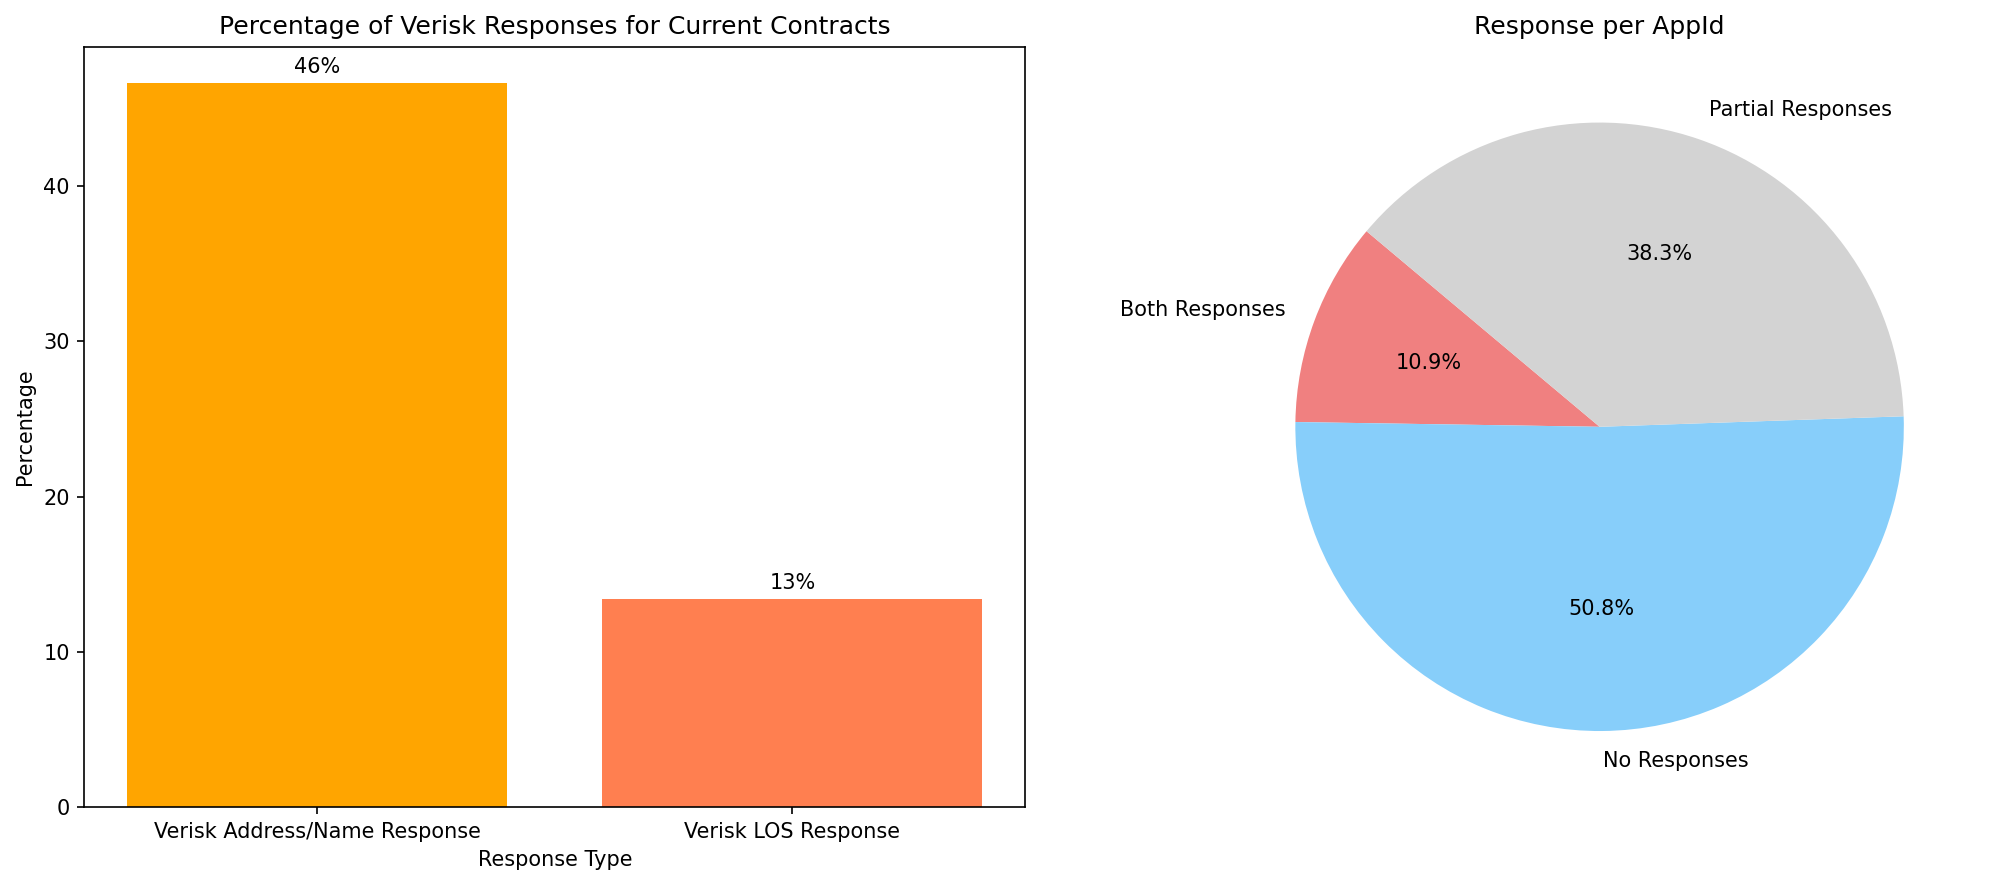

In [66]:
response_counts = df[['Verisk Address/Name Response', 'Verisk LOS Response']].sum()
total_responses = len(df)
response_percentages = (response_counts / total_responses) * 100

#calculate matching and non-matching AppIds
matching_appids = ((df['Verisk Address/Name Response'] == 1) & (df['Verisk LOS Response'] == 1)).sum()
no_response_appids = ((df['Verisk Address/Name Response'] == 0) & (df['Verisk LOS Response'] == 0)).sum()

#pie chart data
matching_data = [matching_appids, no_response_appids, total_responses - matching_appids - no_response_appids]
labels = ['Both Responses', 'No Responses', 'Partial Responses']
colors = ['lightcoral', 'lightskyblue', 'lightgrey']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

#bar chart for response percentages
ax1.bar(response_percentages.index, response_percentages, color=['orange', 'coral'])
ax1.set_title('Percentage of Verisk Responses for Current Contracts')
ax1.set_ylabel('Percentage')
ax1.set_xlabel('Response Type')
ax1.set_xticks(range(len(response_percentages.index)))
ax1.set_xticklabels(response_percentages.index, rotation=0)
for index, value in enumerate(response_percentages):
    ax1.text(index, value + 0.6, f'{int(value)}%', ha='center')

#pie chart
ax2.pie(matching_data, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax2.set_title('Response per AppId')

plt.tight_layout()
plt.savefig('combined_charts.png')
plt.show()

In [1]:
print(response_percentages)

NameError: name 'response_percentages' is not defined

In [22]:
merged2_df

,AppId,DecisionCd,DecisionDesc,TypCd,dealdetailId,DecisionDate,applicant_id,applicant_firstnm,applicant_middlenm,applicant_lastnm,...,overdraftsAndNSFs,negativeBalances,bankStatementsLength,tempAgency,restrictedIncome,incomeVerification,unverifiedIncome,summary,response,incomeDiscrepancy
0,10421504,F,FUNDED,C,16488341,2024-08-14 11:40:49.547,10449087,NIKITA,O,ELLIS GILL,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 1, 'max': 1.1, 'mostRece...","[{'id': 'Adv Plus Banking', 'provided': '350.0...",[],[],"{'grossIncome': 'null', 'avgMonthlyGrossIncome...",[{'employerName': 'ACH CREDIT NEW YORK STATE D...,"{""accountHolderNames"": [""NIKITA OLIVIA ELLIS-G...",{'applicant': {'summary': {'accountHolderNames...,NaN
1,10421572,F,FUNDED,C,16488325,2024-08-15 11:46:21.977,10449080,WADE,NaN,STROBEL,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 0, 'max': 0.0, 'mostRece...","[{'id': 'One Deposit Checking', 'provided': '3...",[],[],"{'grossIncome': 7703.976470588236, 'avgMonthly...",[{'employerName': 'LONGBOAT PRIVATE DIRECT D C...,"{""accountHolderNames"": [""WADE R STROBEL""], ""a...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2024-07', 'percentageDiscrepancy':..."
2,10421640,F,FUNDED,C,16480009,2024-08-13 15:10:57.870,10445076,JOSE,E,QUINONES MILLAN,...,"{'summary': {'count': 1, 'total': 10.0, 'mostR...","{'summary': {'count': 4, 'max': 70.05, 'mostRe...","[{'id': 'Adv Plus Banking', 'provided': '350.0...",[],[],"{'grossIncome': 74525.30588235293, 'avgMonthly...",[{'employerName': 'PRINCE CONTRACTI DES:PAYROL...,"{""accountHolderNames"": [""FRANCES MARY AGUILAR-...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2023-08', 'percentageDiscrepancy':..."
3,10422054,F,FUNDED,C,16487638,2024-08-14 07:02:23.890,10448806,ALONDRA,NaN,SOTO-TAYLOR,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 8, 'max': 32.73, 'mostRe...","[{'id': 'null', 'provided': '350.0', 'extracte...",[],[],"{'grossIncome': 21857.45882352941, 'avgMonthly...",[{'employerName': 'COMPASS GROUP PAYROLL PPD I...,"{""accountHolderNames"": [""Alondra Soto-Taylor""]...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2023-10', 'percentageDiscrepancy':..."
4,10422475,F,FUNDED,C,16481637,2024-08-12 12:49:24.680,10445955,JOHN,NaN,SOARES,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 0, 'max': 0.0, 'mostRece...","[{'id': 'Adv Plus Banking', 'provided': '350.0...",[],[],"{'grossIncome': 71552.45882352942, 'avgMonthly...","[{'employerName': 'self employed', 'startDate'...","{""accountHolderNames"": [""BRANDI SOARES"", ""JOHN...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2023-08', 'percentageDiscrepancy':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,10448622,F,FUNDED,C,16548340,2024-08-23 09:05:05.637,10477172,DANIEL,J,ESCALONA,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 0, 'max': 0.0, 'mostRece...",[{'id': 'WELLS FARGO CLEAR ACCESS BANKING ...9...,[],[],"{'grossIncome': 34891.91764705883, 'avgMonthly...",[{'employerName': 'MOBILE DEPOSIT : REF NUMBER...,"{""accountHolderNames"": [""DANIEL J ESCALONA ROJ...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2023-08', 'percentageDiscrepancy':..."
85,10448766,F,FUNDED,C,16548665,2024-08-22 14:12:53.897,10477309,CHANITTE,C,BYRD,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 0, 'max': 0.0, 'mostRece...","[{'id': 'Varo Checking', 'provided': '350.0', ...",[],[],"{'grossIncome': 7903.235294117648, 'avgMonthly...","[{'employerName': 'FROM Fairview Health, PR PA...","{""accountHolderNames"": [""Chanitte Byrd""], ""add...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2023-08', 'percentageDiscrepancy':..."
86,10448772,F,FUNDED,C,16550018,2024-08-22 14:52:40.293,10477925,JIM,P,BRAGGIO ALIPRANDI,...,"{'summary'

In [30]:
merged2_df = pd.read_csv('v3_resp_0827.tsv',sep='\t')

In [35]:
merged2_df

,AppId,DecisionCd,DecisionDesc,TypCd,dealdetailId,DecisionDate,applicant_id,applicant_firstnm,applicant_middlenm,applicant_lastnm,...,overdraftsAndNSFs,negativeBalances,bankStatementsLength,tempAgency,restrictedIncome,incomeVerification,unverifiedIncome,summary,response,incomeDiscrepancy
0,10421504,F,FUNDED,C,16488341,2024-08-14 11:40:49.547,10449087,NIKITA,O,ELLIS GILL,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 1, 'max': 1.1, 'mostRece...","[{'id': 'Adv Plus Banking', 'provided': '350.0...",[],[],"{'grossIncome': 'null', 'avgMonthlyGrossIncome...",[{'employerName': 'ACH CREDIT NEW YORK STATE D...,"{""accountHolderNames"": [""NIKITA OLIVIA ELLIS-G...",{'applicant': {'summary': {'accountHolderNames...,NaN
1,10421572,F,FUNDED,C,16488325,2024-08-15 11:46:21.977,10449080,WADE,NaN,STROBEL,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 0, 'max': 0.0, 'mostRece...","[{'id': 'One Deposit Checking', 'provided': '3...",[],[],"{'grossIncome': 7703.976470588236, 'avgMonthly...",[{'employerName': 'LONGBOAT PRIVATE DIRECT D C...,"{""accountHolderNames"": [""WADE R STROBEL""], ""a...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2024-07', 'percentageDiscrepancy':..."
2,10421640,F,FUNDED,C,16480009,2024-08-13 15:10:57.870,10445076,JOSE,E,QUINONES MILLAN,...,"{'summary': {'count': 1, 'total': 10.0, 'mostR...","{'summary': {'count': 4, 'max': 70.05, 'mostRe...","[{'id': 'Adv Plus Banking', 'provided': '350.0...",[],[],"{'grossIncome': 74525.30588235293, 'avgMonthly...",[{'employerName': 'PRINCE CONTRACTI DES:PAYROL...,"{""accountHolderNames"": [""FRANCES MARY AGUILAR-...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2023-08', 'percentageDiscrepancy':..."
3,10422054,F,FUNDED,C,16487638,2024-08-14 07:02:23.890,10448806,ALONDRA,NaN,SOTO-TAYLOR,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 8, 'max': 32.73, 'mostRe...","[{'id': 'null', 'provided': '350.0', 'extracte...",[],[],"{'grossIncome': 21857.45882352941, 'avgMonthly...",[{'employerName': 'COMPASS GROUP PAYROLL PPD I...,"{""accountHolderNames"": [""Alondra Soto-Taylor""]...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2023-10', 'percentageDiscrepancy':..."
4,10422475,F,FUNDED,C,16481637,2024-08-12 12:49:24.680,10445955,JOHN,NaN,SOARES,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 0, 'max': 0.0, 'mostRece...","[{'id': 'Adv Plus Banking', 'provided': '350.0...",[],[],"{'grossIncome': 71552.45882352942, 'avgMonthly...","[{'employerName': 'self employed', 'startDate'...","{""accountHolderNames"": [""BRANDI SOARES"", ""JOHN...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2023-08', 'percentageDiscrepancy':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,10448622,F,FUNDED,C,16548340,2024-08-23 09:05:05.637,10477172,DANIEL,J,ESCALONA,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 0, 'max': 0.0, 'mostRece...",[{'id': 'WELLS FARGO CLEAR ACCESS BANKING ...9...,[],[],"{'grossIncome': 34891.91764705883, 'avgMonthly...",[{'employerName': 'MOBILE DEPOSIT : REF NUMBER...,"{""accountHolderNames"": [""DANIEL J ESCALONA ROJ...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2023-08', 'percentageDiscrepancy':..."
85,10448766,F,FUNDED,C,16548665,2024-08-22 14:12:53.897,10477309,CHANITTE,C,BYRD,...,"{'summary': {'count': 0, 'total': 0.0, 'mostRe...","{'summary': {'count': 0, 'max': 0.0, 'mostRece...","[{'id': 'Varo Checking', 'provided': '350.0', ...",[],[],"{'grossIncome': 7903.235294117648, 'avgMonthly...","[{'employerName': 'FROM Fairview Health, PR PA...","{""accountHolderNames"": [""Chanitte Byrd""], ""add...",{'applicant': {'summary': {'accountHolderNames...,"[{'month': '2023-08', 'percentageDiscrepancy':..."
86,10448772,F,FUNDED,C,16550018,2024-08-22 14:52:40.293,10477925,JIM,P,BRAGGIO ALIPRANDI,...,"{'summary'

In [37]:
df_percentages

,name,address,usState,validZipCode,emails,phones,usPhones,overdraftsAndNSFs,negativeBalances,bankStatementsLength,income_monthly,employer_name,time_in_job
0,92.13,49.44,86.52,86.52,60.67,75.28,96.0,85.39,65.17,64.04,15.73,25.84,2.25


In [20]:
print(type(next(iter(data.items()))))

<class 'tuple'>


In [26]:
type(application_data)

str

In [28]:
merged2_df['response'].to_json('glupi4.json', orient='records')

In [7]:
df

,AppId,Response
0,9791874,"{""header"":{""transactionId"":""a6106412-4306-48c6..."
1,9807353,"{""header"":{""transactionId"":""f636f9fc-6706-4ebb..."
2,9814466,"{""header"":{""transactionId"":""9a278df5-a0c1-4671..."
3,9809466,"{""header"":{""transactionId"":""ae8d970b-6554-4d97..."
4,9785216,"{""header"":{""transactionId"":""46b325b7-62ce-4c14..."
...,...,...
1335,9992102,"{""header"":{""transactionId"":""541c1bd8-2d6e-4848..."
1336,9992877,"{""header"":{""transactionId"":""5328c292-719e-443e..."
1337,9993009,"{""header"":{""transactionId"":""4920f89e-154f-425e..."
1338,9974878,"{""header"":{""transactionId"":""168ea83c-a273-4cfd..."


In [69]:
import pandas as pd
import json
from datetime import datetime

#define cancellation phrases and active phrases
cancel_phrases = [
    'Cancel', 'Cancellation', 'Cancellation - Returned Check (NSF)', 
    'Comp Cancel - Non Pay', 'FLAT CANCELS DIFF EFF INCP DATES', 
    'Intent to Cancel Policy', 'Delete Veh'
]
active_phrases = ['Renewal', 'Reinstatement - Lapse in CVG', 'Reinstatement', 'Rescind Intent to Cancel/Non-Renew', 'Endorsement']

#define time periods
first_period_start = datetime(2023, 8, 1)
first_period_end = datetime(2024, 1, 31)  
second_period_start = datetime(2024, 2, 1)
second_period_end = datetime(2024, 7, 31) 

def process_app_id(history_json):
    try:
        response = json.loads(history_json)
    except json.JSONDecodeError:
        #print(f"Failed to decode JSON: {history_json}")
        return {}

    if response.get('body', {}).get('statusCode') == 200:
        policies = response.get('body', {}).get('policies', [])
        
        first_period_dict = {}
        second_period_dict = {}
        
        for policy in policies:
            history = policy.get('history', {})
            transactions = history.get('transactionInformations', [])
            
            for transaction in transactions:
                effective_date_str = transaction.get('effectiveDate')
                if effective_date_str:
                    effective_date = datetime.strptime(effective_date_str, "%Y%m%d")
                    description = transaction.get('transactionType', {}).get('description', '')
                    
                    if first_period_start <= effective_date <= first_period_end:
                        first_period_dict[effective_date] = description
                    if second_period_start <= effective_date <= second_period_end:
                        second_period_dict[effective_date] = description
        
        #sort dictionaries by date to get the last transaction for each period
        first_period_sorted = dict(sorted(first_period_dict.items()))
        second_period_sorted = dict(sorted(second_period_dict.items()))
        
        def check_active_status(period_dict):
            if period_dict:
                last_date = max(period_dict.keys())
                last_description = period_dict[last_date]
                
                if 'Rescind Intent to Cancel/Non-Renew' in last_description:
                    return True  #rescind Intent to Cancel marks the policy as active
                elif any(phrase in last_description for phrase in active_phrases):
                    return True  #active phrases
                elif any(phrase in last_description for phrase in cancel_phrases):
                    return False  #policy was canceled
                else:
                    return True  #no cancellation or active phrases found, still consider active
                
            return None  #none if no transactions are present
        
        #determine if the policy is active or inactive in the periods
        is_active_first_period = check_active_status(first_period_sorted)
        is_active_second_period = check_active_status(second_period_sorted)
        
        return {
            "first_period_active": is_active_first_period,
            "second_period_active": is_active_second_period,
            "last_description_first_period": list(first_period_sorted.values())[-1] if first_period_sorted else 'None',
            "last_description_second_period": list(second_period_sorted.values())[-1] if second_period_sorted else 'None'
        }
    return {}

df = pd.read_csv('Untitled spreadsheet - Sheet7.tsv', sep='\t')

#apply processing to each row
results = []
for _, row in df.iterrows():
    history_json = row.get('Response', '')  
    if pd.notna(history_json) and history_json.strip():  #ensure JSON data is not empty or NaN
        result = process_app_id(history_json)
        results.append({
            'app_id': row.get('AppId', ''),  
            'first_period_active': result.get('first_period_active'),
            'second_period_active': result.get('second_period_active'),
            'last_description_first_period': result.get('last_description_first_period'),
            'last_description_second_period': result.get('last_description_second_period')
        })

results_df = pd.DataFrame(results)
results_df.to_csv('processed2_results.tsv', index=False,sep='\t')


In [71]:
results_df

,app_id,first_period_active,second_period_active,last_description_first_period,last_description_second_period
0,9791874,True,False,Endorsement,Intent to Cancel Policy
1,9807353,True,True,Renewal,Renewal
2,9814466,True,None,Renewal,None
3,9809466,True,True,Endorsement,Renewal
4,9785216,False,True,Cancel,Reinstatement - Lapse in CVG
...,...,...,...,...,...
1286,9992102,True,None,Endorsement,None
1287,9992877,True,True,Renewal,Renewal
1288,9993009,True,True,Endorsement,ENDORSEMENT
1289,9974878,None,None,None,None


In [14]:
df

,AppId,Response
0,9791874,"{""header"":{""transactionId"":""a6106412-4306-48c6..."
1,9807353,"{""header"":{""transactionId"":""f636f9fc-6706-4ebb..."
2,9814466,"{""header"":{""transactionId"":""9a278df5-a0c1-4671..."
3,9809466,"{""header"":{""transactionId"":""ae8d970b-6554-4d97..."
4,9785216,"{""header"":{""transactionId"":""46b325b7-62ce-4c14..."
...,...,...
1335,9992102,"{""header"":{""transactionId"":""541c1bd8-2d6e-4848..."
1336,9992877,"{""header"":{""transactionId"":""5328c292-719e-443e..."
1337,9993009,"{""header"":{""transactionId"":""4920f89e-154f-425e..."
1338,9974878,"{""header"":{""transactionId"":""168ea83c-a273-4cfd..."


In [72]:
df = pd.read_csv('oba_time_perioda_verisk.tsv',sep='\t')
df

,app_id,active_before_funding,active_after_funding
0,9791874,True,False
1,9807353,True,True
2,9809466,True,True
3,9785216,False,True
4,9850698,True,True
...,...,...,...
670,9972354,True,True
671,9991067,True,True
672,9992877,True,True
673,9993009,True,True


In [36]:
df

,app_id,active_before_funding,active_after_funding
0,9791874,NaN,NaN
1,9807353,NaN,NaN
2,9809466,NaN,NaN
3,9785216,NaN,NaN
4,9850698,NaN,NaN
...,...,...,...
670,9972354,NaN,NaN
671,9991067,NaN,NaN
672,9992877,NaN,NaN
673,9993009,NaN,NaN


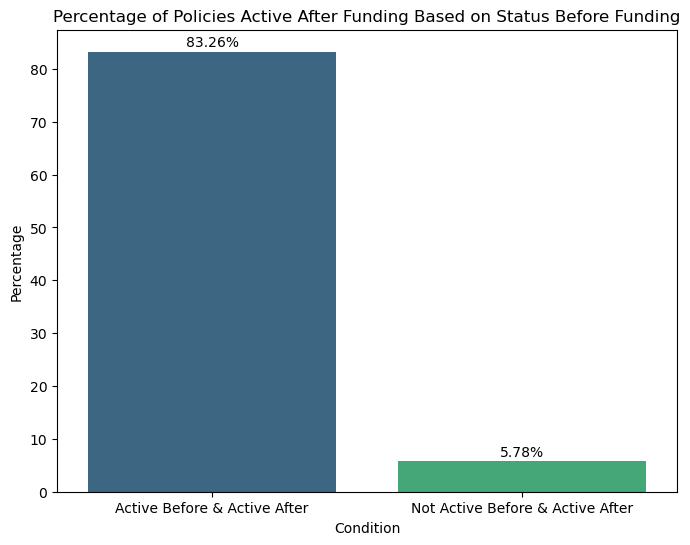

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('oba_time_perioda_verisk.tsv',sep='\t')  

df = df.dropna(subset=['active_before_funding', 'active_after_funding'])
df['active_before_funding'] = df['active_before_funding'].map({True: 1, False: 0})
df['active_after_funding'] = df['active_after_funding'].map({True: 1, False: 0})

#total number of policies
total_policies = df.shape[0]

#calculate counts
active_before_and_active_after = df[(df['active_before_funding'] == 1) & (df['active_after_funding'] == 1)].shape[0]
not_active_before_and_active_after = df[(df['active_before_funding'] == 0) & (df['active_after_funding'] == 1)].shape[0]

#calculate percentages relative to total policies
percent_active_after_given_active_before_total = (active_before_and_active_after / total_policies * 100) if total_policies > 0 else 0
percent_active_after_given_not_active_before_total = (not_active_before_and_active_after / total_policies * 100) if total_policies > 0 else 0


data = {
    'Condition': ['Active Before & Active After', 'Not Active Before & Active After'],
    'Percentage': [percent_active_after_given_active_before_total, percent_active_after_given_not_active_before_total]
}

plot_df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='Condition', y='Percentage', data=plot_df, palette='viridis')

#add annotations on top of the bars
for index, row in plot_df.iterrows():
    bar_plot.text(index, row['Percentage'] + 1, f'{row["Percentage"]:.2f}%', 
                  color='black', ha="center")

plt.xlabel('Condition')
plt.ylabel('Percentage')
plt.title('Percentage of Policies Active After Funding Based on Status Before Funding')
plt.show()


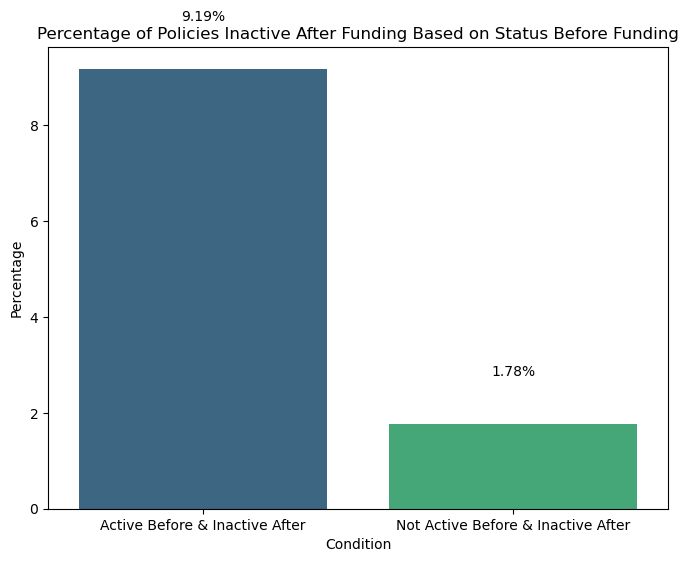

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('oba_time_perioda_verisk.tsv',sep='\t')  

df = df.dropna(subset=['active_before_funding', 'active_after_funding'])
df['active_before_funding'] = df['active_before_funding'].map({True: 1, False: 0})
df['active_after_funding'] = df['active_after_funding'].map({True: 1, False: 0})

#rotal number of policies
total_policies = df.shape[0]

#calculate counts
inactive_after_given_active_before = df[(df['active_before_funding'] == 1) & (df['active_after_funding'] == 0)].shape[0]
inactive_after_given_not_active_before = df[(df['active_before_funding'] == 0) & (df['active_after_funding'] == 0)].shape[0]

#calculate percentages relative to total policies
percent_inactive_after_given_active_before_total = (inactive_after_given_active_before / total_policies * 100) if total_policies > 0 else 0
percent_inactive_after_given_not_active_before_total = (inactive_after_given_not_active_before / total_policies * 100) if total_policies > 0 else 0


data = {
    'Condition': ['Active Before & Inactive After', 'Not Active Before & Inactive After'],
    'Percentage': [percent_inactive_after_given_active_before_total, percent_inactive_after_given_not_active_before_total]
}

plot_df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='Condition', y='Percentage', data=plot_df, palette='viridis')

#add annotations on top of the bars
for index, row in plot_df.iterrows():
    bar_plot.text(index, row['Percentage'] + 1, f'{row["Percentage"]:.2f}%', 
                  color='black', ha="center")

plt.xlabel('Condition')
plt.ylabel('Percentage')
plt.title('Percentage of Policies Inactive After Funding Based on Status Before Funding')
plt.show()


In [1]:

active_before_and_active_after = df[(df['active_before_funding'] == 1) & (df['active_after_funding'] == 1)].shape[0]
total_active_before = df[df['active_before_funding'] == 1].shape[0]

likelihood_active_after_given_active_before = (active_before_and_active_after / total_active_before) * 100

print(f"Likelihood of being active after funding given being active before funding: {likelihood_active_after_given_active_before:.2f}%")


NameError: name 'df' is not defined

In [50]:
total_active_before

624

In [51]:
total_not_active_before

51

In [52]:
active_before_and_active_after

562

In [54]:
not_active_before_and_active_after

39

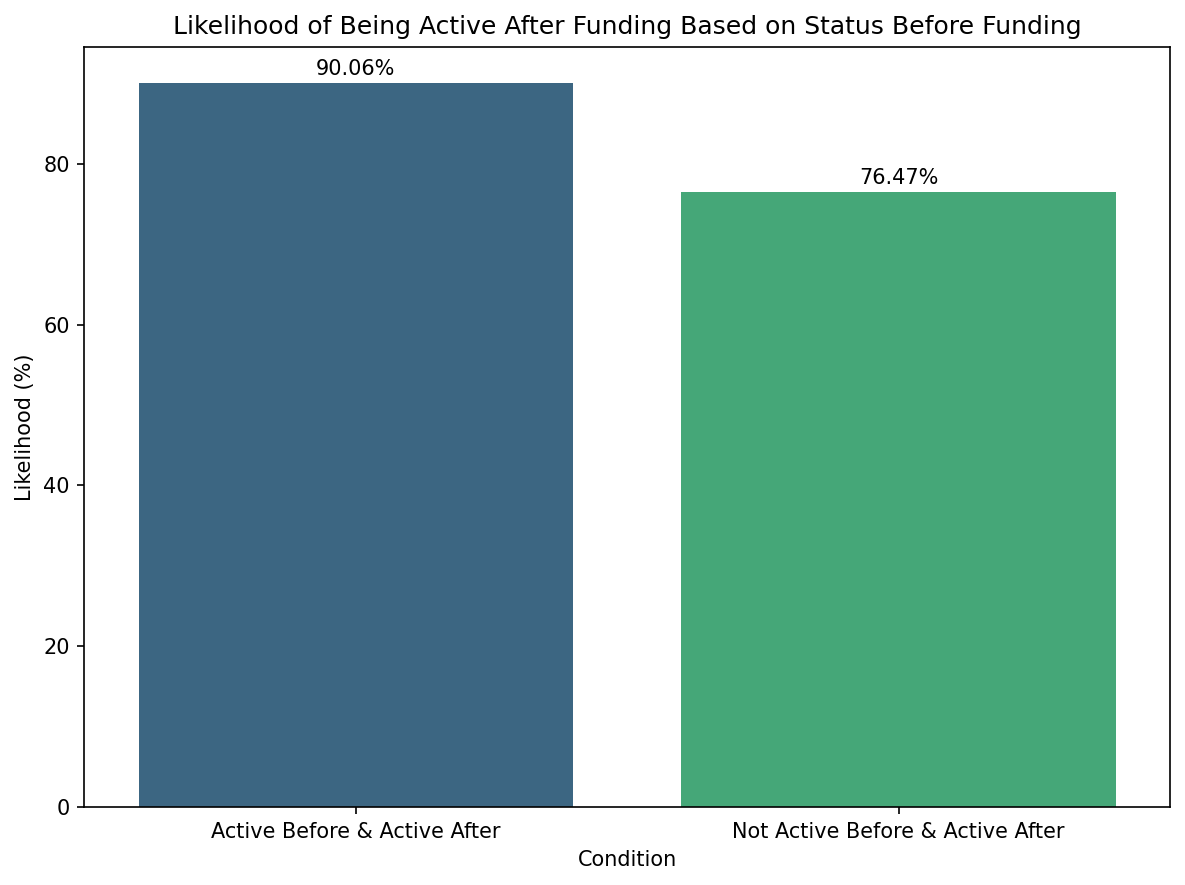

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('oba_time_perioda_verisk.tsv',sep='\t')  

df = df.dropna(subset=['active_before_funding', 'active_after_funding'])
df['active_before_funding'] = df['active_before_funding'].map({True: 1, False: 0})
df['active_after_funding'] = df['active_after_funding'].map({True: 1, False: 0})

#total number of policies
total_policies = df.shape[0]

#calculate counts for active after funding in both cases
active_before_and_active_after = df[(df['active_before_funding'] == 1) & (df['active_after_funding'] == 1)].shape[0]
not_active_before_and_active_after = df[(df['active_before_funding'] == 0) & (df['active_after_funding'] == 1)].shape[0]

total_active_before = df[df['active_before_funding'] == 1].shape[0]
total_not_active_before = df[df['active_before_funding'] == 0].shape[0]

#calculate likelihoods
likelihood_active_after_given_active_before = (active_before_and_active_after / total_active_before) * 100 if total_active_before > 0 else 0
likelihood_active_after_given_not_active_before = (not_active_before_and_active_after / total_not_active_before) * 100 if total_not_active_before > 0 else 0


data = {
    'Condition': ['Active Before & Active After', 'Not Active Before & Active After'],
    'Likelihood (%)': [likelihood_active_after_given_active_before, likelihood_active_after_given_not_active_before]
}

plot_df = pd.DataFrame(data)

plt.figure(figsize=(8, 6),dpi=150)
bar_plot = sns.barplot(x='Condition', y='Likelihood (%)', data=plot_df, palette='viridis')

#add annotations on top of the bars
for index, row in plot_df.iterrows():
    bar_plot.text(index, row['Likelihood (%)'] + 1, f'{row["Likelihood (%)"]:.2f}%', 
                  color='black', ha="center")

plt.xlabel('Condition')
plt.ylabel('Likelihood (%)')
plt.title('Likelihood of Being Active After Funding Based on Status Before Funding')
plt.tight_layout()
plt.savefig('active_after.png')


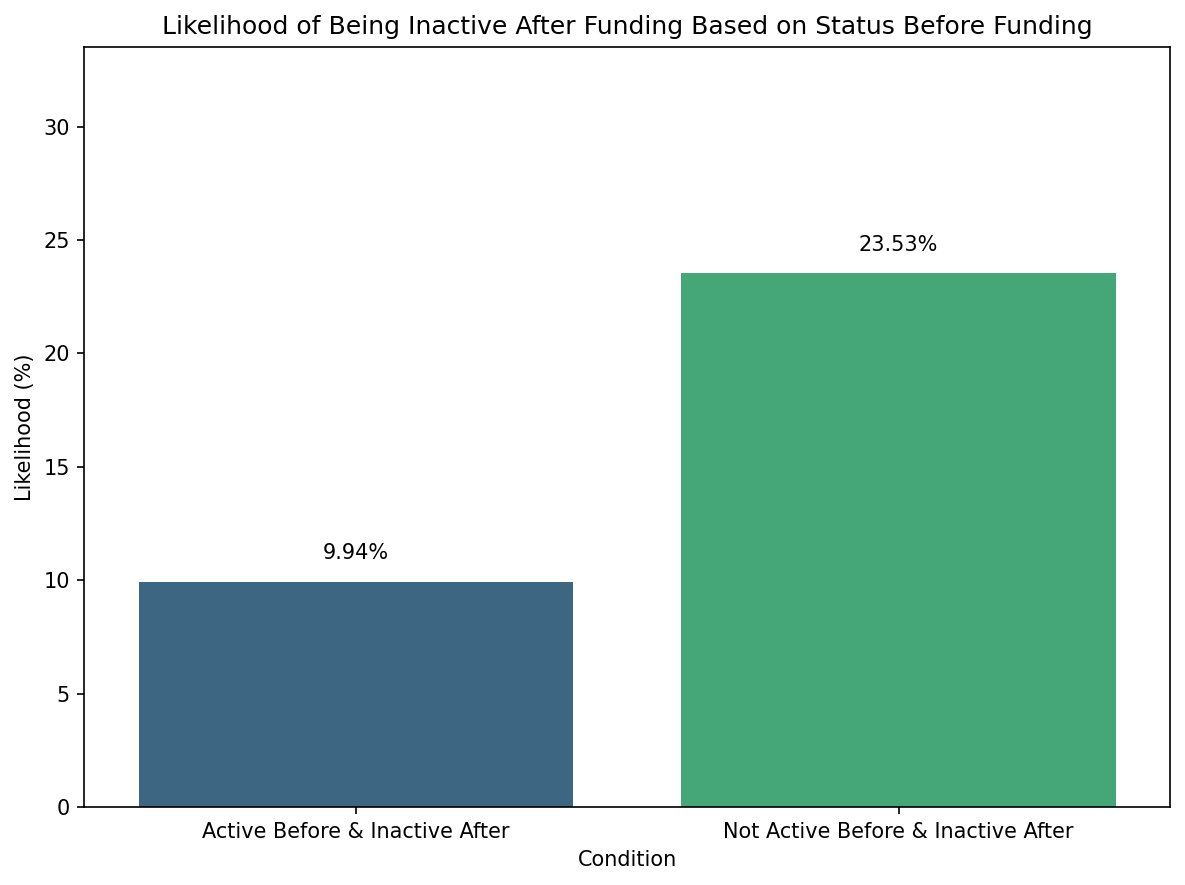

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('oba_time_perioda_verisk.tsv', sep='\t')  


df = df.dropna(subset=['active_before_funding', 'active_after_funding'])
df['active_before_funding'] = df['active_before_funding'].map({True: 1, False: 0})
df['active_after_funding'] = df['active_after_funding'].map({True: 1, False: 0})

#total number of policies
total_policies = df.shape[0]

#calculate counts for inactive after funding in both cases
active_before_and_inactive_after = df[(df['active_before_funding'] == 1) & (df['active_after_funding'] == 0)].shape[0]
not_active_before_and_inactive_after = df[(df['active_before_funding'] == 0) & (df['active_after_funding'] == 0)].shape[0]

total_active_before = df[df['active_before_funding'] == 1].shape[0]
total_not_active_before = df[df['active_before_funding'] == 0].shape[0]

#calculate likelihoods for inactive after funding
likelihood_inactive_after_given_active_before = (active_before_and_inactive_after / total_active_before) * 100 if total_active_before > 0 else 0
likelihood_inactive_after_given_not_active_before = (not_active_before_and_inactive_after / total_not_active_before) * 100 if total_not_active_before > 0 else 0


data = {
    'Condition': ['Active Before & Inactive After', 'Not Active Before & Inactive After'],
    'Likelihood (%)': [likelihood_inactive_after_given_active_before, likelihood_inactive_after_given_not_active_before]
}

plot_df = pd.DataFrame(data)

#plot percentages
plt.figure(figsize=(8, 6),dpi=150)
bar_plot = sns.barplot(x='Condition', y='Likelihood (%)', data=plot_df, palette='viridis')

plt.ylim(0, plot_df['Likelihood (%)'].max() + 10)

#add annotations above the bars
for index, row in plot_df.iterrows():
    bar_plot.text(index, row['Likelihood (%)'] + 1, f'{row["Likelihood (%)"]:.2f}%', 
                  color='black', ha="center")

plt.xlabel('Condition')
plt.ylabel('Likelihood (%)')
plt.title('Likelihood of Being Inactive After Funding Based on Status Before Funding')
plt.tight_layout()
plt.savefig('inactive_after.png')

In [66]:
active_before_and_active_after

562

In [79]:
df.rename(columns={"app_id": "AppId"},inplace=True)

In [80]:
df

,AppId,active_before_funding,active_after_funding
0,9791874,True,False
1,9807353,True,True
2,9809466,True,True
3,9785216,False,True
4,9850698,True,True
...,...,...,...
670,9972354,True,True
671,9991067,True,True
672,9992877,True,True
673,9993009,True,True


In [75]:
df_1 = pd.read_csv('verisk_sql_odys_80.tsv',sep='\t')
df_1

,AppId,DealDetailId,DecisionDate,PolicyNum,VIN,applicant_firstnm,applicant_middlenm,applicant_lastnm,applicant_suffix,AptNo,StreetNo,Street,StreetTyp,City,State,PostalCd
0,9786868,14954148,2024-02-13 08:16:34.487,044090900c,1C6RR7FG5JS265147,DAREN,NaN,JONES,JR,NaN,986,Cabo Blanco,Ave E,Jacksonville,FL,32233.0
1,9791874,14975067,2024-02-13 08:39:27.210,P020089362301,KL4CJASB7FB119251,FRANK,NaN,NOGUERA,NaN,402,13455,NE 10th,Ave,North Miami,FL,33161.0
2,9737647,14999769,2024-02-16 14:22:42.590,025888483C,5N1AL0MN5FC546619,DAISIA,NaN,BROWN,NaN,NaN,487,Brooke Hampton,Dr,Tallahassee,FL,32311.0
3,9807353,14999919,2024-02-13 10:02:30.577,CSFL405698,1J4NT4FA7AD506191,WHITNEY,NaN,ALBRIGHT,NaN,NaN,12020,Pitcairn,St,Brooksville,FL,34613.0
4,9814466,15013153,2024-02-13 13:46:14.077,UCD000690931,1FDWE3FL8FDA04499,KIM,G,PETIT,NaN,NaN,1311,NE 144th,St,Miami,FL,33161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,9993009,15411662,2024-02-27 11:13:54.043,CAAS 227550397,WDBSK75F55F093643,MITCHELL,M,BALCOMBE,NaN,NaN,2425,Ventana View,Way,Modesto,CA,95355.0
2371,9974878,15412128,2024-02-27 17:36:45.467,4571489,WA1LGAFE1FD033036,TIERRA,NaN,ALLEN,NaN,408,2111,Holly Hall,St,Houston,TX,77054.0
2372,9990019,15412774,2024-02-27 13:18:10.667,6038450448,1C4PJMLB9KD431013,JAIONIE,C,MARTINEZ,NaN,1805,657,Worcester,St,Southbridge,MA,1550.0
2373,9961303,15415967,2024-02-27 14:30:20.937,3386402D1332,5FRYD4H55HB022098,WILLIAM,NaN,TORRES,NaN,1B,817,Faile,St,Bronx,NY,10474.0


In [76]:
df_1 = df_1[['AppId','State']]
df_1

,AppId,State
0,9786868,FL
1,9791874,FL
2,9737647,FL
3,9807353,FL
4,9814466,FL
...,...,...
2370,9993009,CA
2371,9974878,TX
2372,9990019,MA
2373,9961303,NY


In [81]:
df_mergovano = pd.merge(df,df_1,on='AppId',how='inner')

In [82]:
df_mergovano

,AppId,active_before_funding,active_after_funding,State
0,9791874,True,False,FL
1,9807353,True,True,FL
2,9809466,True,True,FL
3,9785216,False,True,FL
4,9850698,True,True,MA
...,...,...,...,...
672,9972354,True,True,PA
673,9991067,True,True,TX
674,9992877,True,True,AZ
675,9993009,True,True,CA


In [85]:
df_active_before = df_mergovano[(df_mergovano['active_before_funding']== True) & (df_mergovano['active_after_funding']== False)]

In [87]:
df_active_before['State'].value_counts()

FL    35
TX     6
MA     3
AR     3
NC     2
AL     2
VA     2
NY     2
OH     1
CT     1
PA     1
OK     1
SC     1
LA     1
GA     1
Name: State, dtype: int64

In [88]:
df_mergovano['State'].value_counts()

FL    224
CA     40
NC     39
TX     38
MA     33
AR     32
NY     31
GA     21
VA     20
PA     19
OH     19
CO     16
NJ     16
AZ     15
AL     13
CT     11
LA      9
SC      9
NE      8
TN      7
IN      7
OK      5
ME      4
KY      4
NH      4
NV      3
MO      3
HI      3
MD      3
NM      2
MT      2
KS      2
IL      2
MS      2
WY      2
MN      2
WA      2
VT      1
SD      1
WV      1
IA      1
DE      1
Name: State, dtype: int64

In [89]:
df_mergovano

,AppId,active_before_funding,active_after_funding,State
0,9791874,True,False,FL
1,9807353,True,True,FL
2,9809466,True,True,FL
3,9785216,False,True,FL
4,9850698,True,True,MA
...,...,...,...,...
672,9972354,True,True,PA
673,9991067,True,True,TX
674,9992877,True,True,AZ
675,9993009,True,True,CA


In [90]:
3500/224

15.625

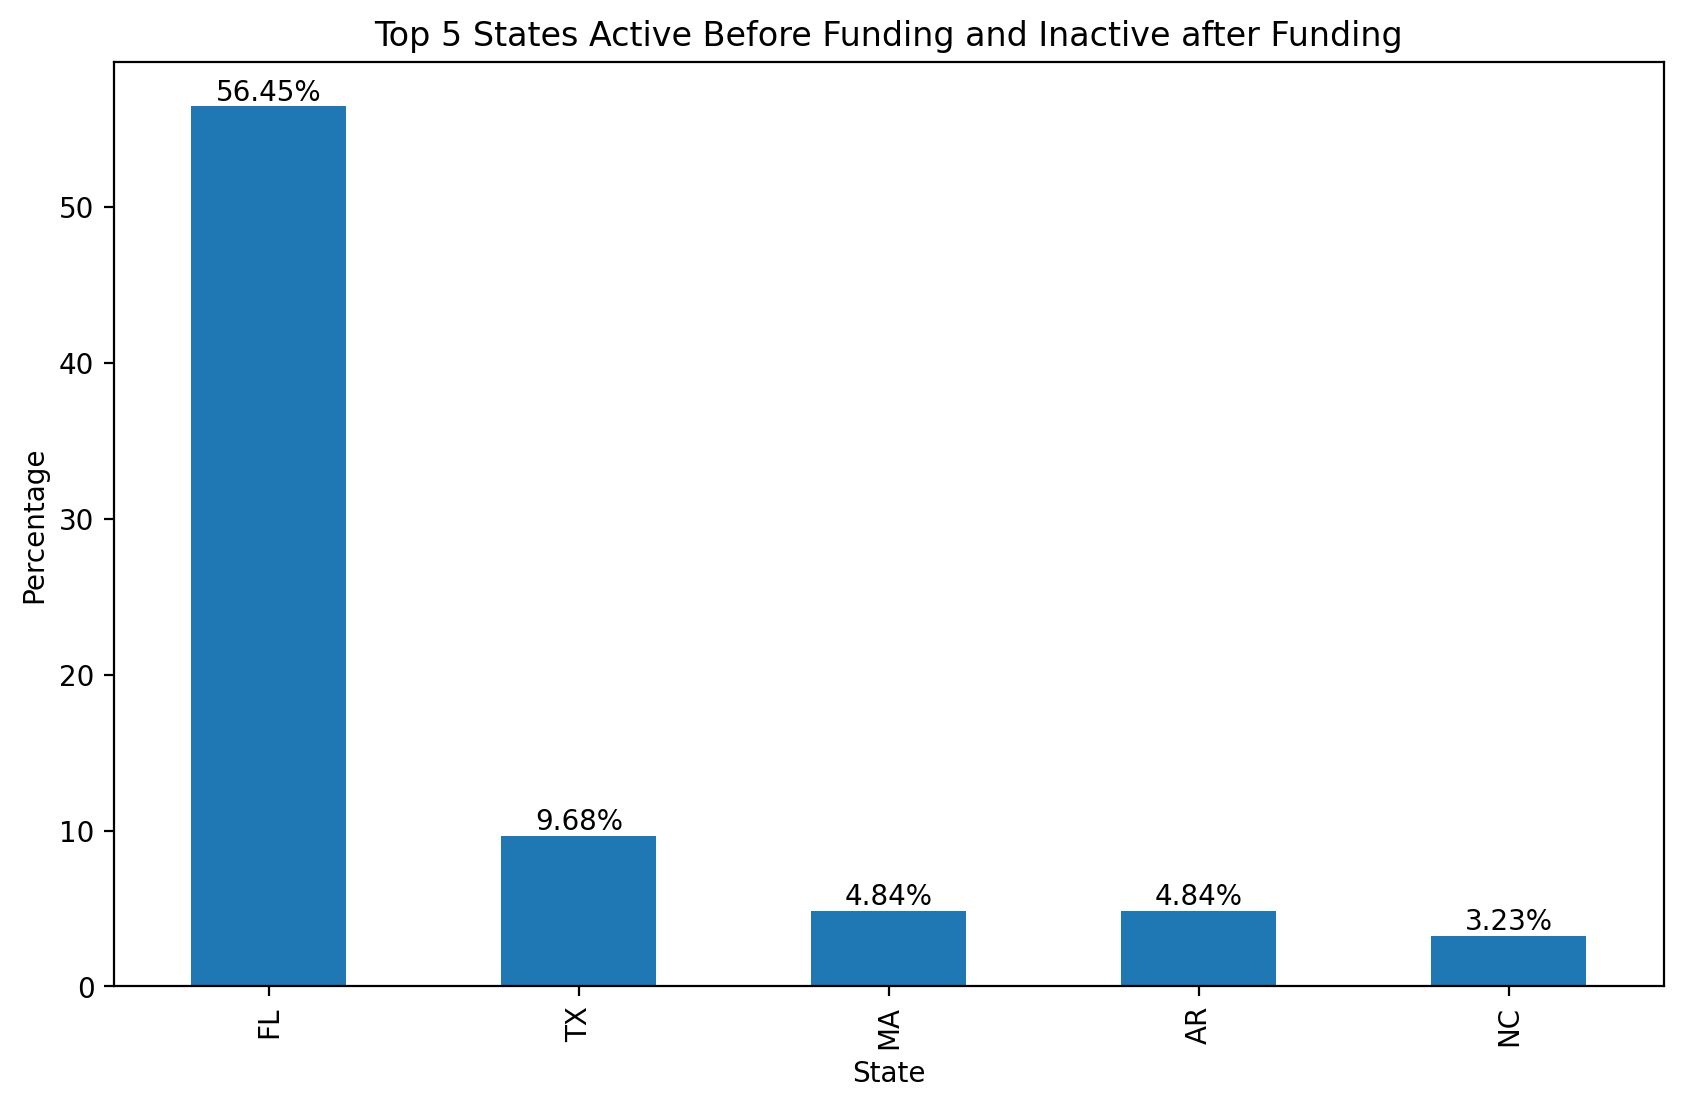

In [113]:
state_counts = df_active_before['State'].value_counts(normalize=True) * 100

#top 5 active before funding and inactive after funding
top_5_states = state_counts.head(5)

plt.figure(figsize=(10, 6),dpi=200)
bars = top_5_states.plot(kind='bar')

#add percentage labels on top of each bar
for bar in bars.patches:
    bars.annotate(f'{bar.get_height():.2f}%', 
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                  ha='center', va='bottom')

plt.title('Top 5 States Active Before Funding and Inactive after Funding')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.savefig('odys-85.png')

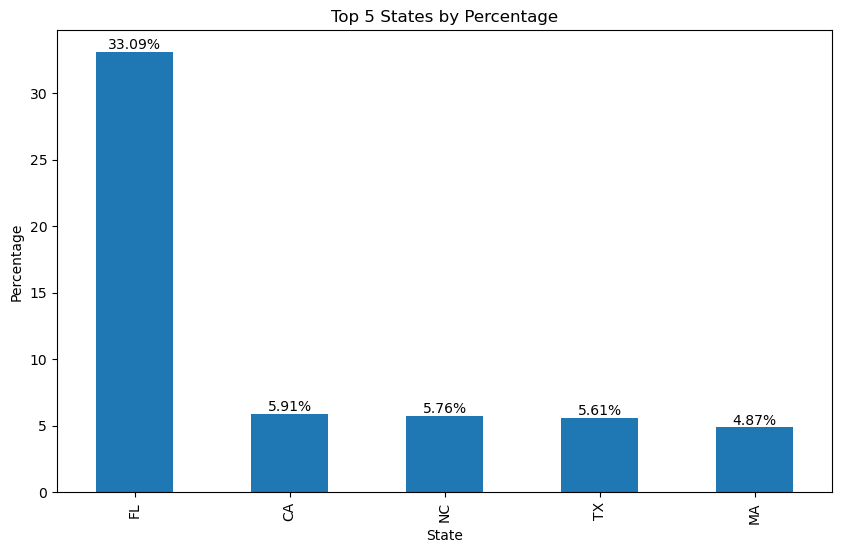

In [101]:
state_counts = df_mergovano['State'].value_counts(normalize=True) * 100

#get the top 5 states by percentage
top_5_states = state_counts.head(5)


plt.figure(figsize=(10, 6))
bars = top_5_states.plot(kind='bar')

#add percentage labels on top of each bar
for bar in bars.patches:
    bars.annotate(f'{bar.get_height():.2f}%', 
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                  ha='center', va='bottom')

plt.title('Top 5 States by Percentage')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.show()

In [104]:
df_zz = df_mergovano[(df_mergovano['active_after_funding']== True)]
df_zz

,AppId,active_before_funding,active_after_funding,State
1,9807353,True,True,FL
2,9809466,True,True,FL
3,9785216,False,True,FL
4,9850698,True,True,MA
5,9876089,True,True,CO
...,...,...,...,...
672,9972354,True,True,PA
673,9991067,True,True,TX
674,9992877,True,True,AZ
675,9993009,True,True,CA


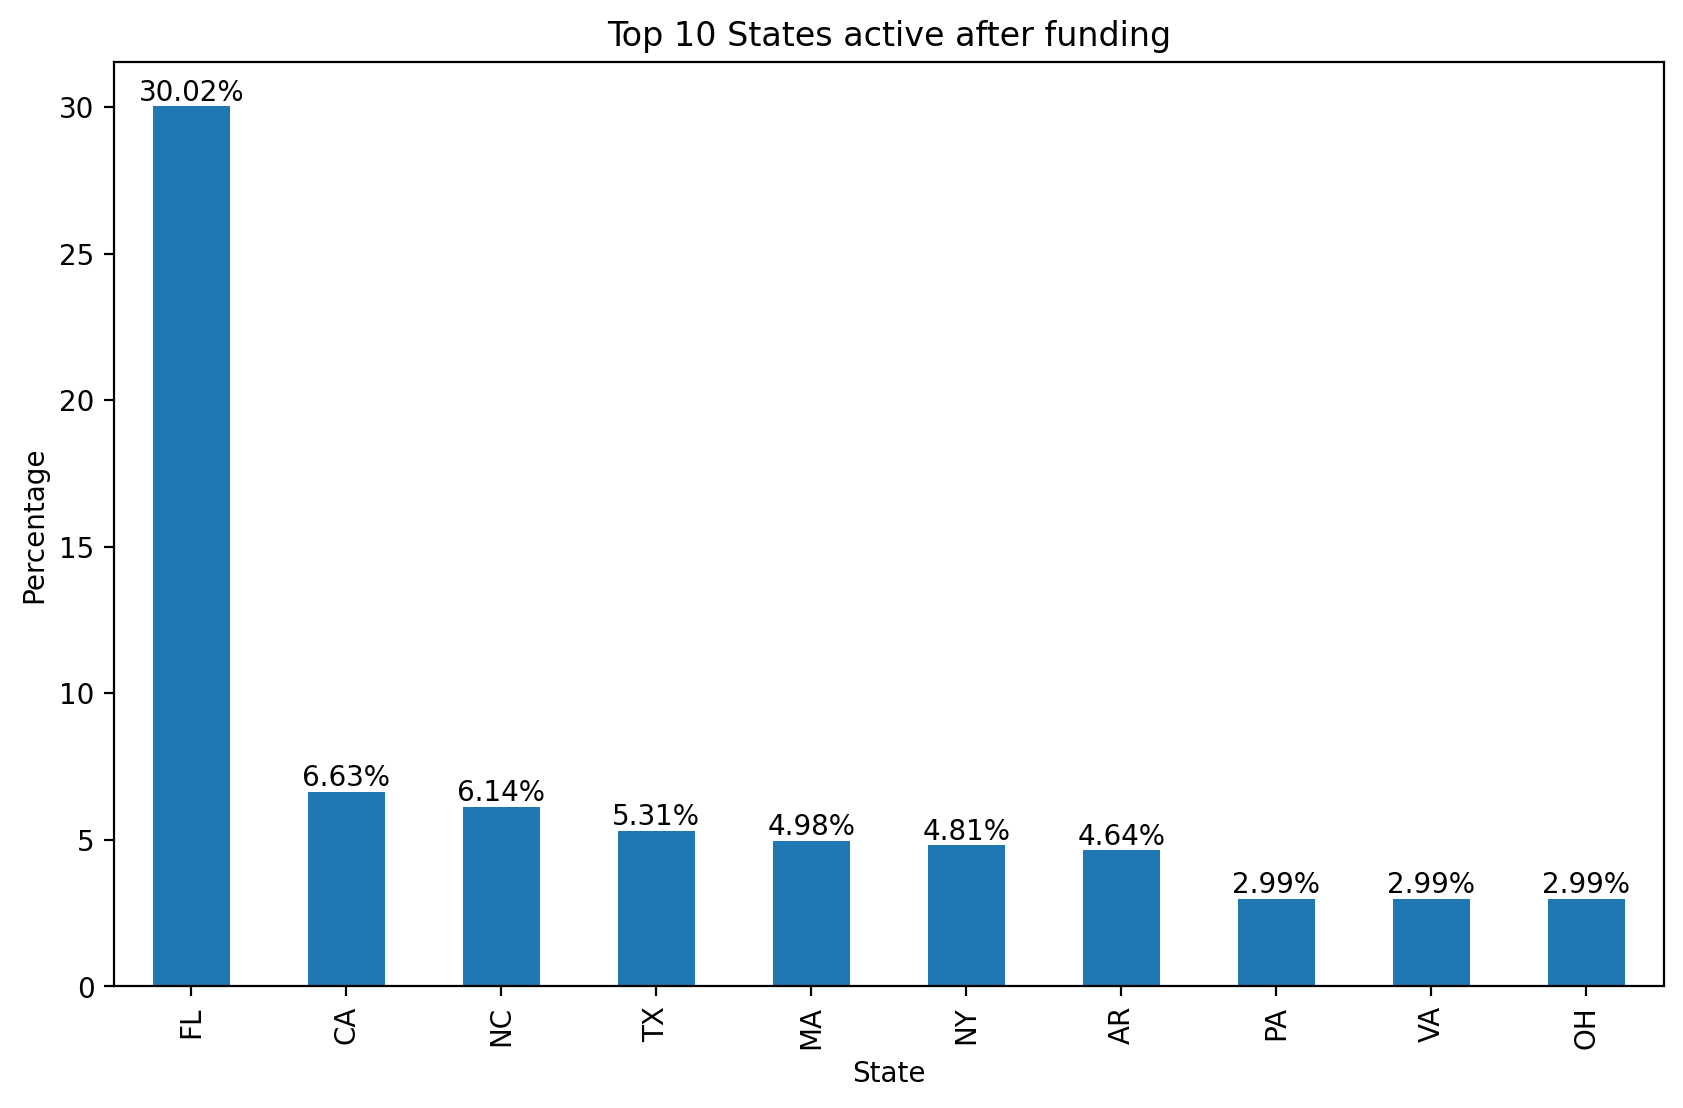

In [116]:
state_counts = df_zz['State'].value_counts(normalize=True) * 100

#get top 10 states after funding
top_10_states = state_counts.head(10)


plt.figure(figsize=(10, 6),dpi=200)
bars = top_10_states.plot(kind='bar')

#add percentage on top of each bar
for bar in bars.patches:
    bars.annotate(f'{bar.get_height():.2f}%', 
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                  ha='center', va='bottom')

plt.title('Top 10 States active after funding')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.savefig('top_10_states.png')

In [115]:
results_df[results_df['second_period_active']]

,app_id,first_period_active,second_period_active,last_description_first_period,last_description_second_period
0,9791874,True,False,Endorsement,Intent to Cancel Policy
1,9807353,True,True,Renewal,Renewal
2,9814466,True,None,Renewal,None
3,9809466,True,True,Endorsement,Renewal
4,9785216,False,True,Cancel,Reinstatement - Lapse in CVG
...,...,...,...,...,...
1286,9992102,True,None,Endorsement,None
1287,9992877,True,True,Renewal,Renewal
1288,9993009,True,True,Endorsement,ENDORSEMENT
1289,9974878,None,None,None,None


In [117]:
df_state = pd.read_csv('verisk_sql_odys_80.tsv',sep='\t')
df_state

,AppId,DealDetailId,DecisionDate,PolicyNum,VIN,applicant_firstnm,applicant_middlenm,applicant_lastnm,applicant_suffix,AptNo,StreetNo,Street,StreetTyp,City,State,PostalCd
0,9786868,14954148,2024-02-13 08:16:34.487,044090900c,1C6RR7FG5JS265147,DAREN,NaN,JONES,JR,NaN,986,Cabo Blanco,Ave E,Jacksonville,FL,32233.0
1,9791874,14975067,2024-02-13 08:39:27.210,P020089362301,KL4CJASB7FB119251,FRANK,NaN,NOGUERA,NaN,402,13455,NE 10th,Ave,North Miami,FL,33161.0
2,9737647,14999769,2024-02-16 14:22:42.590,025888483C,5N1AL0MN5FC546619,DAISIA,NaN,BROWN,NaN,NaN,487,Brooke Hampton,Dr,Tallahassee,FL,32311.0
3,9807353,14999919,2024-02-13 10:02:30.577,CSFL405698,1J4NT4FA7AD506191,WHITNEY,NaN,ALBRIGHT,NaN,NaN,12020,Pitcairn,St,Brooksville,FL,34613.0
4,9814466,15013153,2024-02-13 13:46:14.077,UCD000690931,1FDWE3FL8FDA04499,KIM,G,PETIT,NaN,NaN,1311,NE 144th,St,Miami,FL,33161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,9993009,15411662,2024-02-27 11:13:54.043,CAAS 227550397,WDBSK75F55F093643,MITCHELL,M,BALCOMBE,NaN,NaN,2425,Ventana View,Way,Modesto,CA,95355.0
2371,9974878,15412128,2024-02-27 17:36:45.467,4571489,WA1LGAFE1FD033036,TIERRA,NaN,ALLEN,NaN,408,2111,Holly Hall,St,Houston,TX,77054.0
2372,9990019,15412774,2024-02-27 13:18:10.667,6038450448,1C4PJMLB9KD431013,JAIONIE,C,MARTINEZ,NaN,1805,657,Worcester,St,Southbridge,MA,1550.0
2373,9961303,15415967,2024-02-27 14:30:20.937,3386402D1332,5FRYD4H55HB022098,WILLIAM,NaN,TORRES,NaN,1B,817,Faile,St,Bronx,NY,10474.0


Text(0, 0.5, 'Percentage')

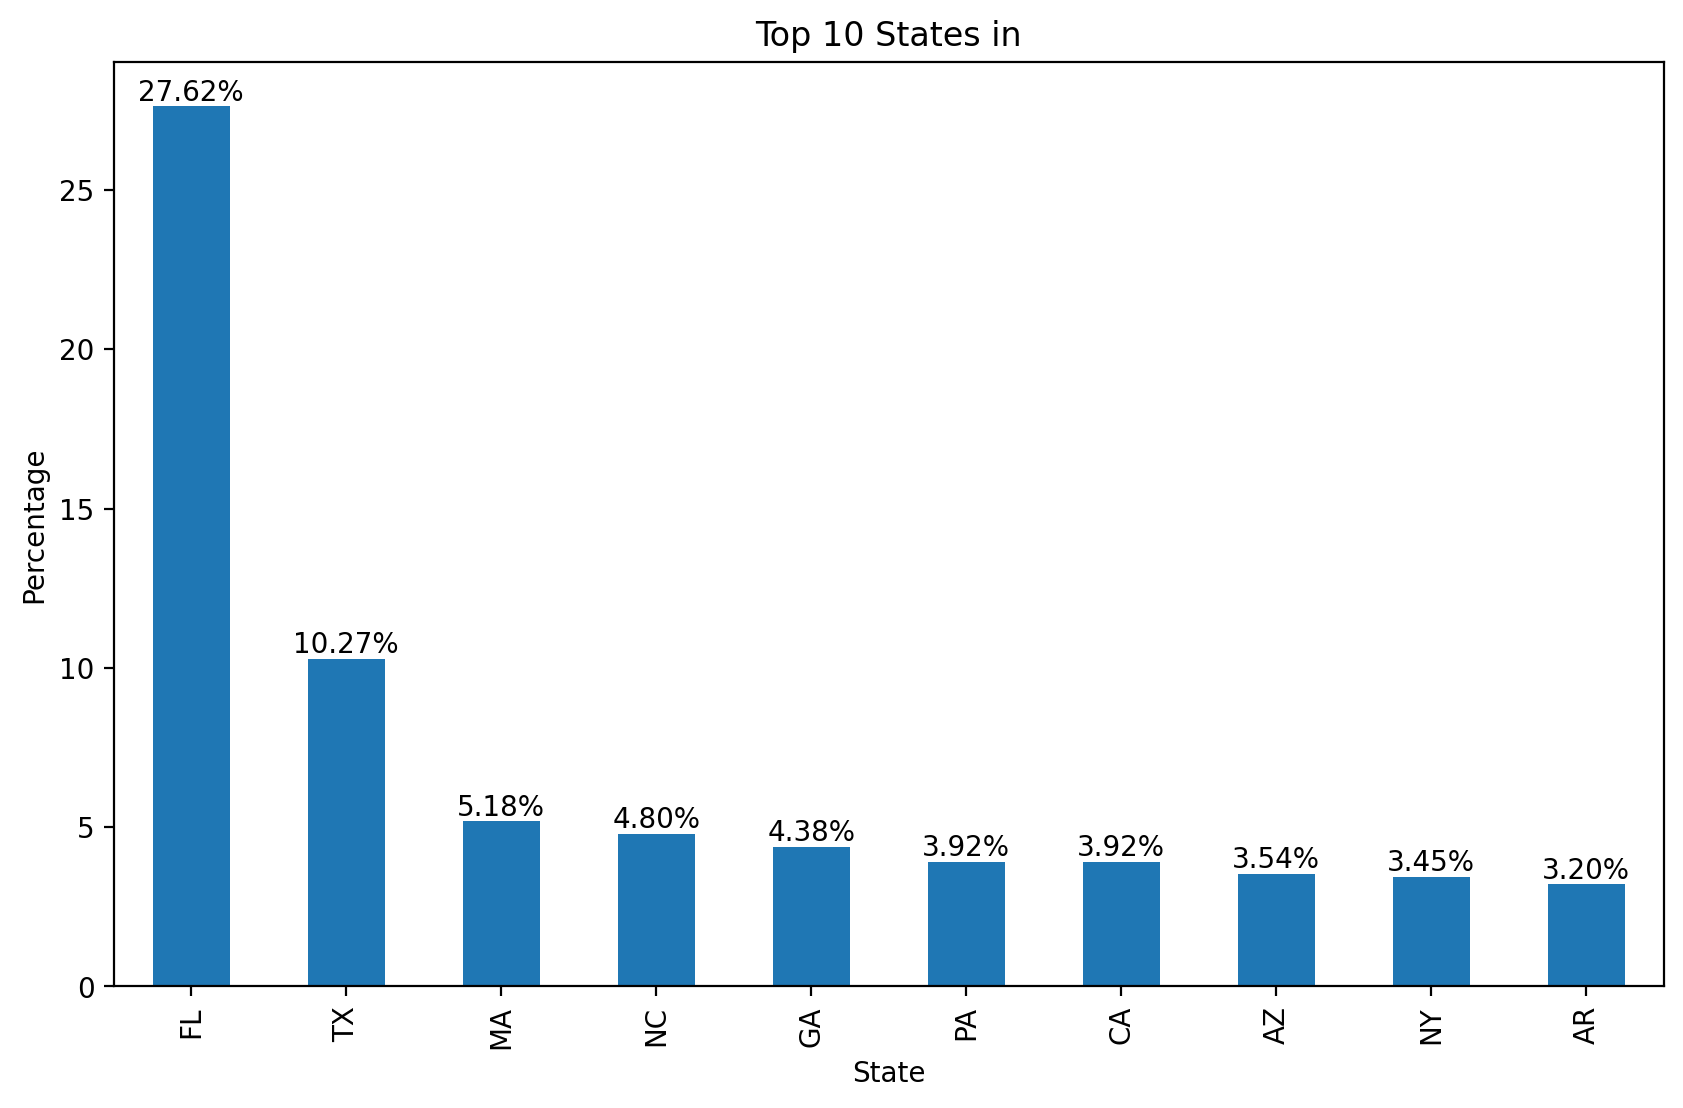

In [120]:
state_counts = df_state['State'].value_counts(normalize=True) * 100

#top 10 states in the sample
top_10_states = round(state_counts.head(10),2)

plt.figure(figsize=(10, 6),dpi=200)
bars = top_10_states.plot(kind='bar')

#add percentage labels on top of each bar
for bar in bars.patches:
    bars.annotate(f'{bar.get_height():.2f}%', 
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                  ha='center', va='bottom')

plt.title('Top 10 States in')
plt.xlabel('State')
plt.ylabel('Percentage')
#plt.savefig('top_10_states.png')

In [121]:
top_5_states

FL    27.62
TX    10.27
MA     5.18
NC     4.80
GA     4.38
PA     3.92
CA     3.92
AZ     3.54
NY     3.45
AR     3.20
Name: State, dtype: float64